<a href="https://colab.research.google.com/github/frpbotero/bank_customer_churn_analysis/blob/main/bank_customer_churn_analysis_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Instalações e importações

In [1]:
!pip install pandas
!pip install kaggle --upgrade
!pip install xgboost lightgbm catboost
!pip install feature_engine
!pip install imblearn
!pip install seaborn
!pip install dotenv


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# ==========================
# 1. Bibliotecas Básicas
# ==========================
import os
import pandas as pd
from IPython.display import Markdown, display

# ==========================
# 2. Visualização
# ==========================
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# ==========================
# 3. Estatística
# ==========================
import scipy.stats as stats
from scipy.stats import pearsonr, mannwhitneyu, kruskal, chi2_contingency

# ==========================
# 4. Pré-processamento
# ==========================
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    OneHotEncoder,
    label_binarize
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer

# ==========================
# 5. Modelos de Machine Learning
# ==========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# ==========================
# 6. Clusterização
# ==========================
from sklearn.cluster import KMeans, DBSCAN

# ==========================
# 7. Avaliação de Modelos
# ==========================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# ==========================
# 8. Validação e Otimização
# ==========================
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)

# ==========================
# 9. Pipelines e Redução de Dimensão
# ==========================
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline

# ==========================
# 10. Balanceamento de Classes
# ==========================
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# ==========================
# 11. Persistência
# ==========================
import joblib

# ==========================
# 12. Recursos Específicos
# ==========================
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
try:
    k_username = os.getenv('KAGGLE_USERNAME')
    k_key = os.getenv('KAGGLE_KEY')

    if not k_username or not k_key:
        raise ValueError("Chaves não encontradas no arquivo .env")

    os.environ["KAGGLE_USERNAME"] = k_username
    os.environ["KAGGLE_KEY"] = k_key

    print("Credenciais configuradas com sucesso.")

    import kaggle

    

except Exception as e:
    print(f"Erro: {e}")
    print("Certifique-se de que o arquivo .env existe e contém KAGGLE_USERNAME e KAGGLE_KEY.")

Credenciais configuradas com sucesso.


## Introdução

A retenção de clientes é um dos pilares essenciais para a sustentabilidade financeira de qualquer empresa do setor bancário. A perda de clientes — conhecida como churn — representa não apenas redução imediata de receita, mas também custos adicionais para aquisição de novos consumidores e possíveis impactos na reputação da instituição. Compreender os fatores que levam um cliente a encerrar seu relacionamento é, portanto, um passo decisivo para construir estratégias mais eficazes de fidelização.

Este projeto tem como objetivo analisar e interpretar as variáveis associadas ao churn em um banco fictício, identificando padrões, correlações e pesos relativos de cada feature no comportamento de saída dos clientes. A partir desse entendimento, busca-se responder à dor central do negócio: por que clientes deixam o banco e como podemos antecipar esses casos?

O sucesso, dentro deste contexto, está diretamente relacionado à capacidade de prever a probabilidade de churn com precisão e orientar ações práticas que reduzam a perda de clientes. Quanto melhor o modelo entender os fatores críticos de evasão, maior será a possibilidade de intervenção preventiva e, consequentemente, de retenção.

## Sobre o Dataset


O dataset utilizado neste estudo é o repositório público radheshyamkollipara/bank-customer-churn, composto por 10.000 registros e 18 variáveis que descrevem informações demográficas, características de conta, produtos financeiros e o indicador final de churn. Embora fictício, o conjunto de dados apresenta complexidade suficiente para simular um cenário realista de análise de comportamento de clientes no ambiente bancário.

In [4]:
import kaggle
# Definir o nome do dataset
dataset_name = 'radheshyamkollipara/bank-customer-churn'

# Opcional: Criar um diretório para o dataset
download_path = './kaggle_data'
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Baixar o dataset
print(f"Baixando o dataset {dataset_name}...")
kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)
print(f"Dataset baixado e descompactado em {download_path}/")

# Listar os arquivos baixados (opcional)
print("Arquivos baixados:")
for file_name in os.listdir(download_path):
    print(f"- {file_name}")

# Encontrar o arquivo CSV principal e carregar no pandas
csv_file = None
for file_name in os.listdir(download_path):
    if file_name.endswith('.csv'):
        csv_file = os.path.join(download_path, file_name)
        break

if csv_file:
    print(f"Carregando o arquivo {csv_file} em um DataFrame do pandas...")
    df_model = pd.read_csv(csv_file)
    display(df_model.head())
else:
    print("Nenhum arquivo CSV encontrado no dataset baixado.")

Baixando o dataset radheshyamkollipara/bank-customer-churn...
Dataset URL: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn
Dataset baixado e descompactado em ./kaggle_data/
Arquivos baixados:
- Customer-Churn-Records.csv
Carregando o arquivo ./kaggle_data\Customer-Churn-Records.csv em um DataFrame do pandas...


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \
0        101348.88       1         1                   2   DIAMOND   
1        112542.58       0         1                   3   DIAMOND   
2        113931.57       1         1                   3   DIAMOND   
3         93826.63       0         0                   5      GOLD   
4         79084.10       0         0                   5      GOLD   

   Point Earned  
0           464  
1           456  
2           377  
3           350  
4           425

## Informações do Dataset

In [5]:
print("Analise de Features\n")
print(df_model.info())

print("\nVerificando valores unicos\n")
print(df_model.nunique())

Analise de Features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-nul

## Verificando valores nulos ou faltantes

In [6]:
print(df_model.isnull().sum())

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


### Remoção de colunas irrelevantes para o modelo

In [7]:
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df_model = df_model.drop(cols_to_drop, axis=1)

# Analise Exploratória de Dados (EDA)

## Analise Univariada

### Definição de Variáveis

In [8]:
var_qualitativas = ["IsActiveMember", "HasCrCard", "Gender", "Exited", "Geography", "Card Type", "Complain"]
var_quantitativas = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary", "Satisfaction Score", "Point Earned"]

NUMERIC_FEATURES = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Point Earned']
CATEGORICAL_FEATURES = ['Geography', 'Gender', 'Card Type', 'HasCrCard', 'IsActiveMember']

In [9]:
print("Informações do Dataset")
display(Markdown("### Variaveis Qualitativas"))
display(df_model[var_qualitativas].astype('object').describe())

display(Markdown("### Variaveis Quantitativas"))
display(df_model[var_quantitativas].describe())

Informações do Dataset


### Variaveis Qualitativas

IsActiveMember  HasCrCard Gender  Exited Geography Card Type  Complain
count            10000      10000  10000   10000     10000     10000     10000
unique               2          2      2       2         3         4         2
top                  1          1   Male       0    France   DIAMOND         0
freq              5151       7055   5457    7962      5014      2507      7956

### Variaveis Quantitativas

CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

       EstimatedSalary  Satisfaction Score  Point Earned  
count     10000.000000        10000.000000  10000.000000  
mean     100090.239881            3.013800    606.515100  
std       57510.492818            1.405919    225.924839  
min          11.580000            1.000000    119.000000  
25%       51002.110000            2.000000    410.000000  
50%      100193.915000            3.000000    605.000000  
75%      149388.247500            4.000000    801.000000  
max      199992.480000            5.000000   1000.000000

#### Váriaveis Qualitativas

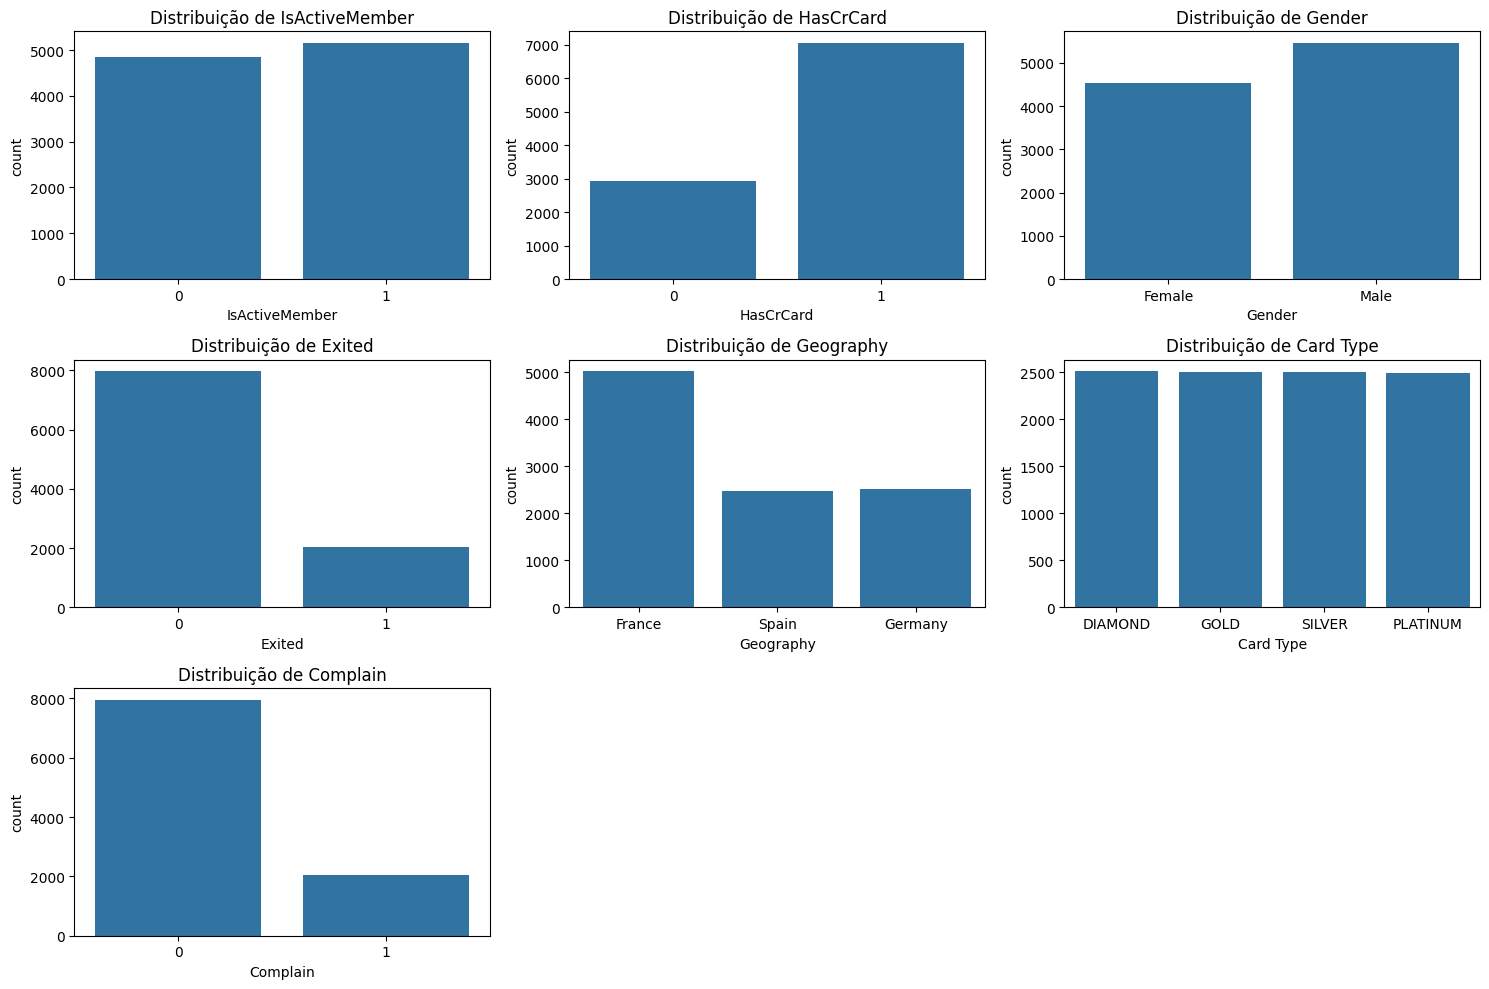

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

for i, col in enumerate(var_qualitativas):
    plt.subplot(3, 3, i + 1) 
    sns.countplot(data=df_model, x=col)
    plt.title(f'Distribuição de {col}')
    plt.tight_layout()

plt.show()

---

### 📈 Análise das Variáveis Qualitativas

#### 🟦 **Atividade e Engajamento**

* **50% dos clientes permanecem ativos** na base.
* **20% dos clientes saíram** (exit), indicando churn relevante.

#### 💳 **Uso de Produtos**

* **70% dos clientes possuem cartão de crédito.**

#### 👥 **Perfil Demográfico**

* **Mais de 50% dos clientes são homens.**
* **50% dos clientes são da França.**

#### 📞 **Relacionamento**

* **80% dos clientes não fizeram reclamações**, um volume significativamente maior que o dos clientes que registraram algum problema.

#### 📅 **Histórico**

* **Tempo máximo de permanência:** 10 anos.

---

#### ⚠️ **Pontos de Atenção (Resumo Crítico)**

* **A variável alvo é fortemente desbalanceada**, exigindo técnicas específicas para evitar vieses durante o treinamento do modelo.
* **Predomínio de clientes franceses** pode introduzir vieses geográficos, especialmente se o comportamento financeiro for distinto entre franceses, espanhóis e alemães.

---

#### 🧭 **Conclusão (Simplificada)**

A base apresenta **boa adesão a produtos**, **poucas reclamações** e **engajamento razoável**, mas o **churn de 20%** e o **desbalanceamento da variável alvo** devem ser tratados cuidadosamente para garantir modelos preditivos mais consistentes.

---


#### Variaveis Quantitativas

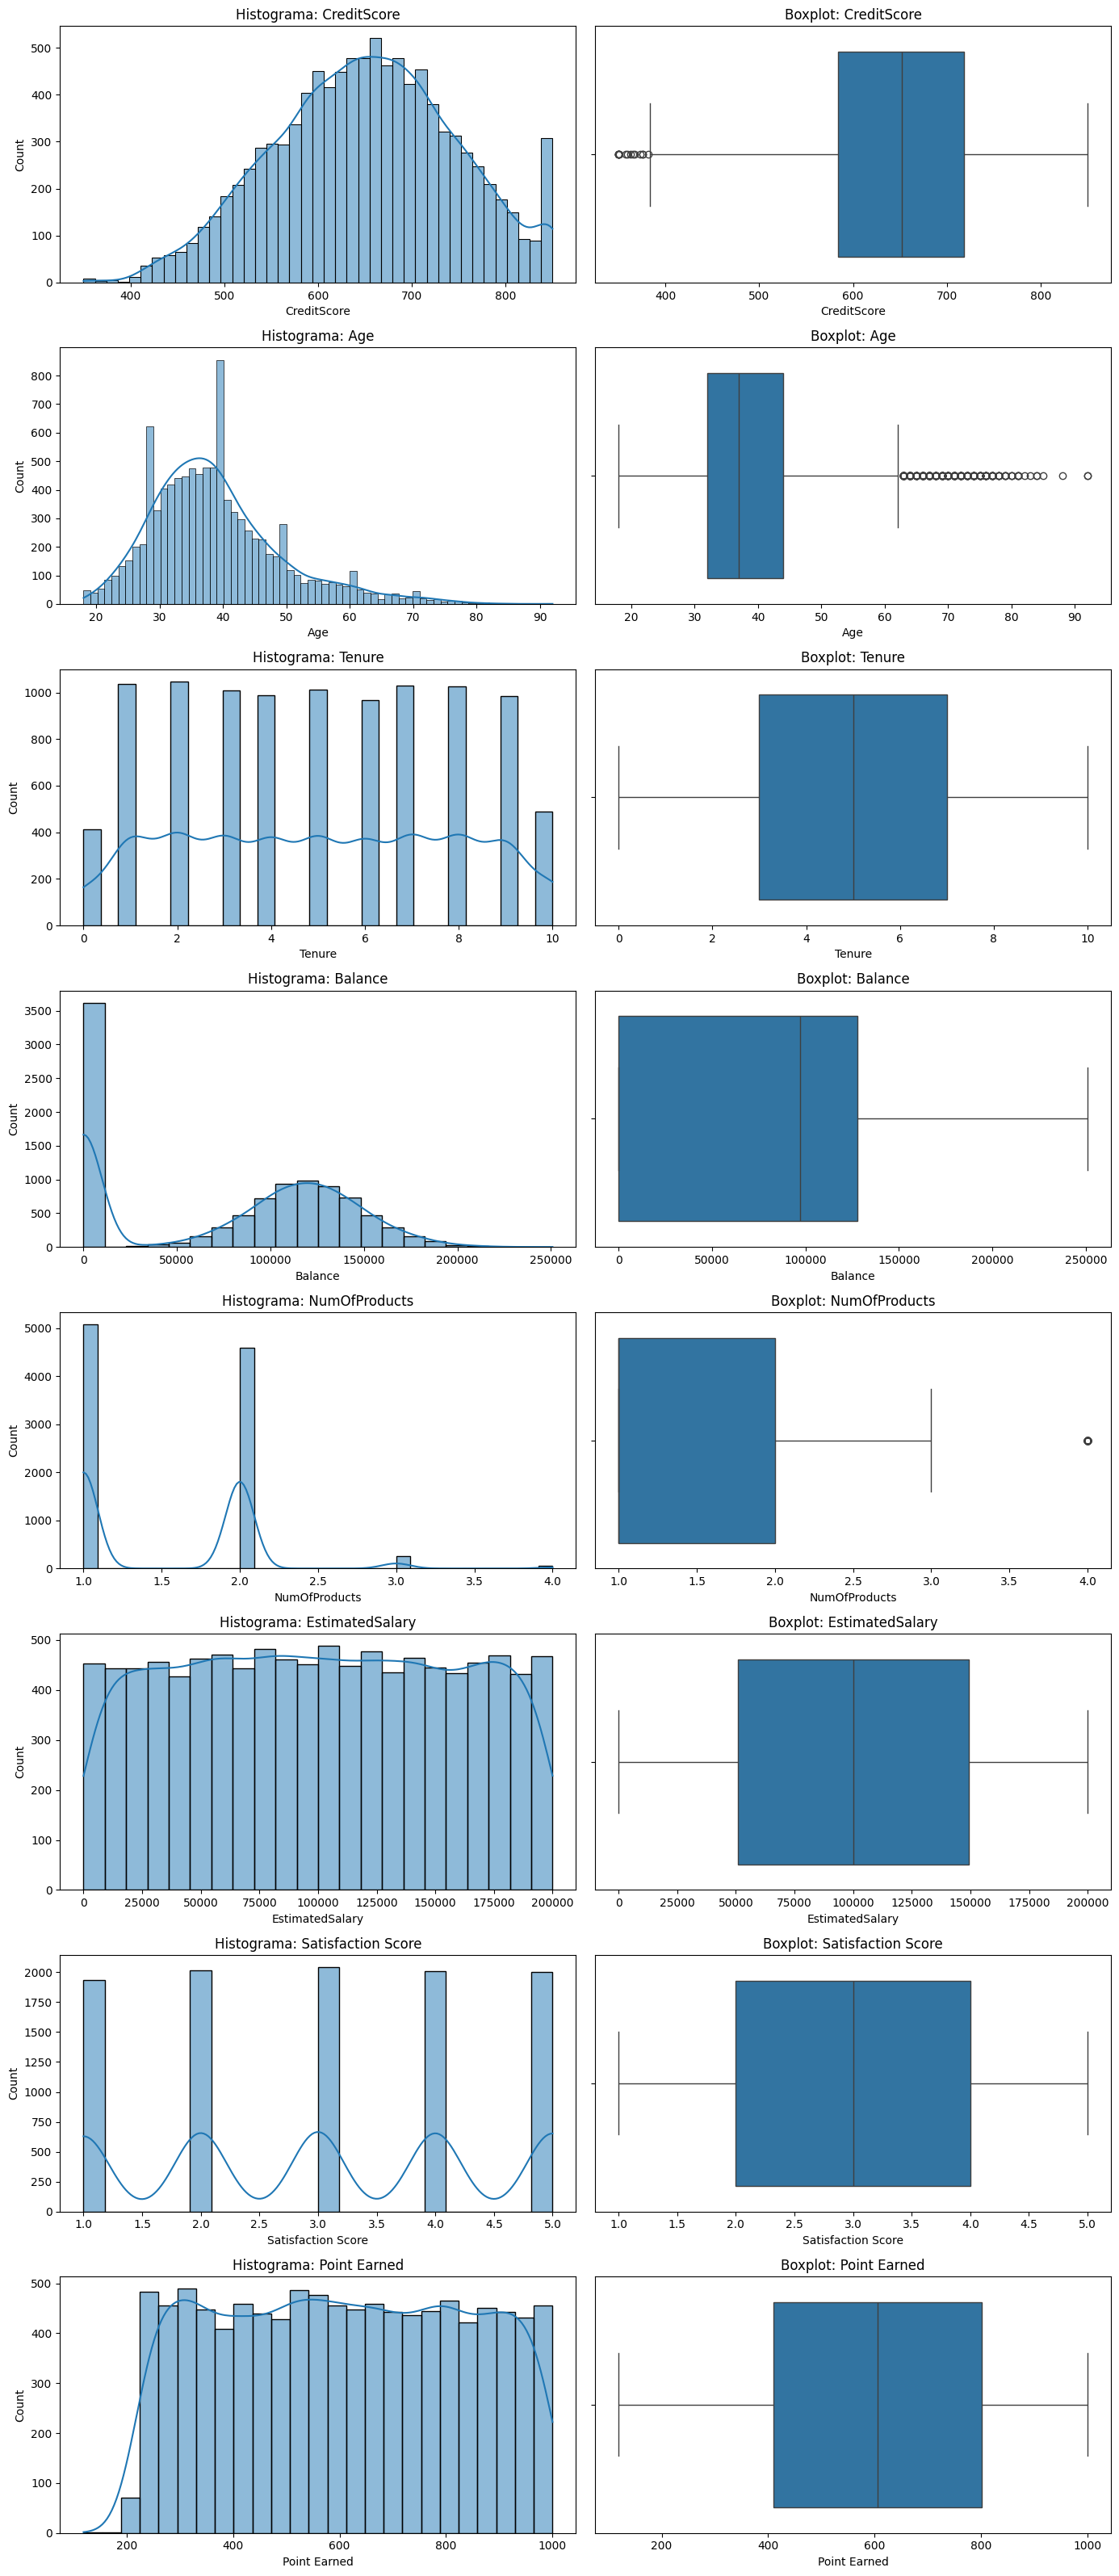

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajustando o tamanho para caber tudo
fig, axes = plt.subplots(len(var_quantitativas), 2, figsize=(14, len(var_quantitativas) * 4))

for i, col in enumerate(var_quantitativas):
    # Histograma (lado esquerdo)
    sns.histplot(data=df_model, x=col, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histograma: {col}')

    # Boxplot (lado direito)
    sns.boxplot(data=df_model, x=col, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

---

### 📈 **Análise das Variáveis Quantitativas**

#### ⭐ **Credit Score**

* A distribuição é **levemente deslocada para a esquerda**, indicando que a pontuação de crédito tende a ser **um pouco mais alta**.
* Isso sugere que a base é composta majoritariamente por **clientes com bom perfil de crédito**.

---

#### 👤 **Idade**

* A idade apresenta distribuição **suavemente inclinada à esquerda**, mostrando **maior concentração de clientes jovens**.
* A faixa predominante está entre **32 e 45 anos**.
* Existem **alguns outliers acima de 64 anos**, mas representam minoria.

---

#### 🕒 **Tempo de Relacionamento**

* **Menos de 400 clientes têm menos de 1 ano de relacionamento**.
* O tempo máximo é de **10 anos**, mas representa apenas cerca de **500 clientes**.
* A maior concentração está no intervalo de **3 a 7 anos**, exibindo **distribuição bastante uniforme** nessa faixa.

---

#### 🏦 **Balanço (Saldo em Conta)**

* **Mais de 45% dos clientes não possuem saldo**, o que pode indicar:

  * Contas recém-criadas sem movimentação, ou
  * Clientes que não utilizam o banco como instituição financeira principal.

---

#### 📦 **Número de Produtos**

* **Mais de 50% dos clientes possuem pelo menos 1 produto**.
* **Cerca de 40% possuem 2 produtos**.
* Aproximadamente **200 clientes possuem 3 produtos** do banco.

---

#### 💼 **Estimativa Salarial**

* A distribuição de salário é **uniforme**, com maior concentração no intervalo de **50.000 a 150.000**.

---

#### ⭐ **Nota de Satisfação**

* A distribuição das notas é equilibrada, com **maior frequência de avaliações acima de 2 pontos** — sinalizando tendência à satisfação moderada ou elevada.

---


## Analise Bivariada

#### Váriaveis Quantitativa

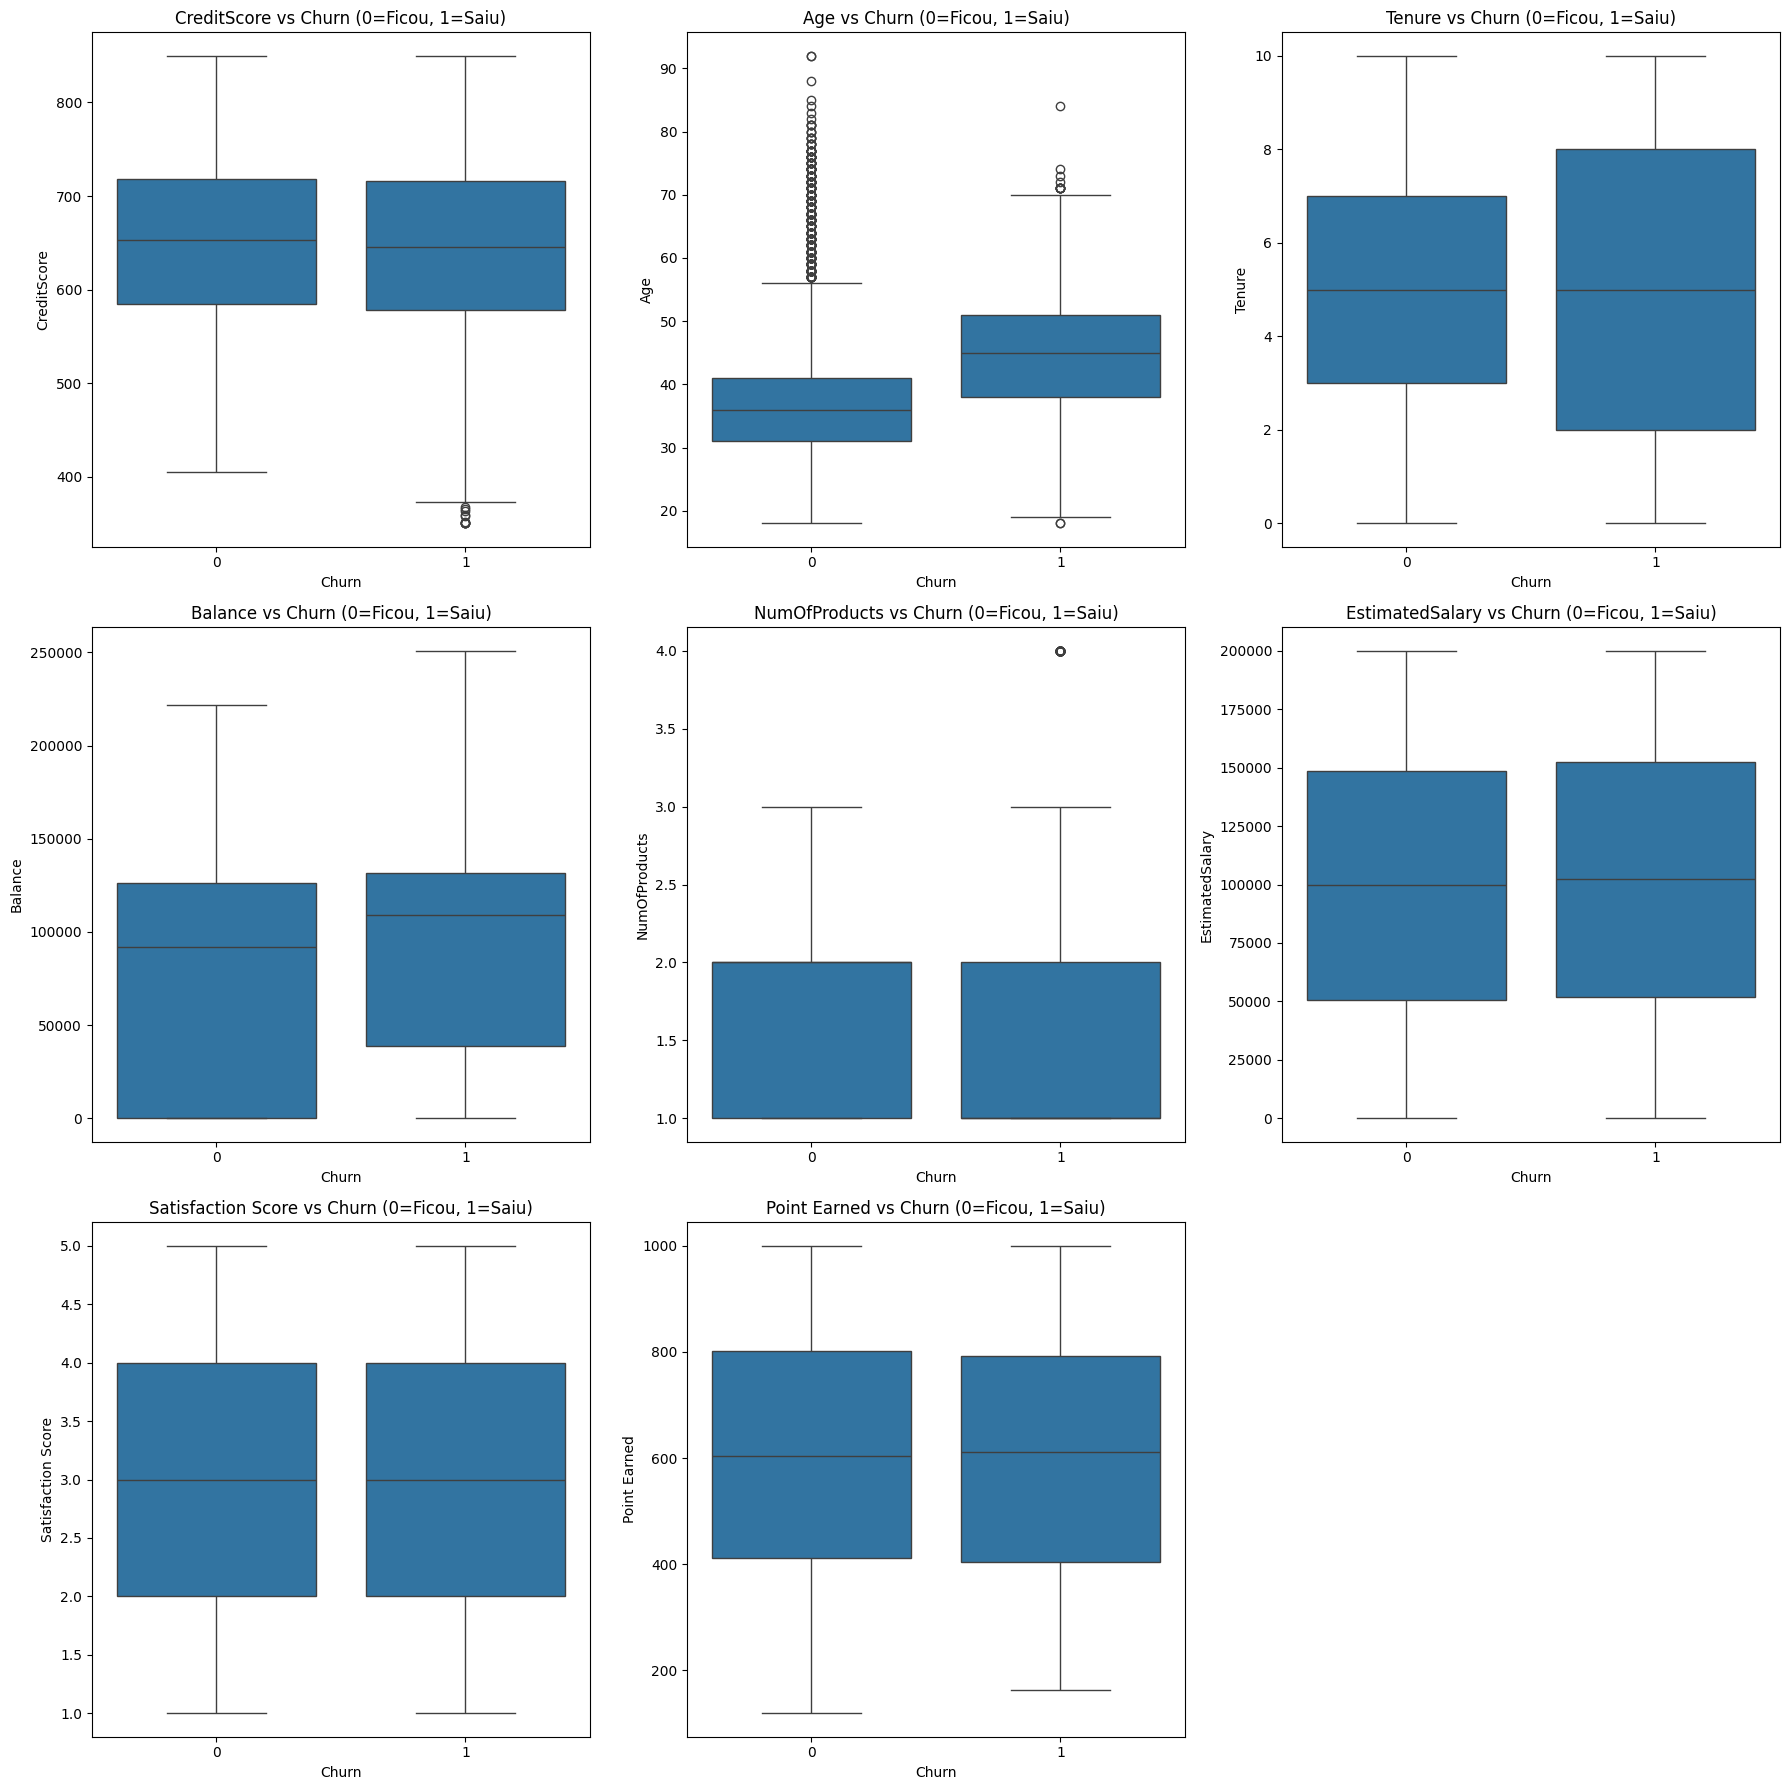

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

n = len(var_quantitativas)

cols = 3
rows = (n + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()  

for i, col in enumerate(var_quantitativas):
    sns.boxplot(data=df_model, x='Exited', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs Churn (0=Ficou, 1=Saiu)', fontsize=12)
    axes[i].set_xlabel("Churn")
    axes[i].set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [13]:
df_model.groupby('Exited')['NumOfProducts'].value_counts(normalize=True)

Exited  NumOfProducts
0       2                0.532655
        1                0.461567
        3                0.005777
1       1                0.691364
        2                0.171246
        3                0.107949
        4                0.029441
Name: proportion, dtype: float64

---

#### 📈 Análise das Variáveis Quantitativas

##### ⭐ **1. Idade é um fator crítico para churn**

* Clientes que saem são **claramente mais velhos**.
* A mediana geral fica em torno de **45 anos**, mas o grupo churn tem idades ainda mais elevadas.
  **Conclusão:** idade é um dos preditores mais fortes de churn.

---

#### ⭐ **2. Número de produtos diferencia fortemente quem sai de quem fica**

Mesmo que o boxplot não evidencie, a proporção deixa claro:

##### 🔹 Quem tem **1 produto**:

* **69% do churn** pertence a esse grupo.
* Apenas **46% dos clientes que ficam** têm 1 produto.
  ➡️ **Grande indicador de risco.**

##### 🔹 Quem tem **2 produtos**:

* **53% dos clientes que ficam** têm 2 produtos.
* Apenas **17% dos clientes que saem** têm 2 produtos.
  ➡️ **Indica retenção.**

##### 🔹 Quem tem 3 ou 4 produtos:

* Casos raros, mas aparecem mais no churn do que entre os que ficaram.
  ➡️ Pode sinalizar perfis específicos ou necessidades não atendidas.

---

#### ⭐ **3. Clientes com contas sem saldo são predominantes**

* Mais de **45% não possuem saldo**.
  ➡️ Pode indicar baixa movimentação, uso secundário da conta ou simples inatividade.
  ➡️ Sinal de **risco potencial**, pois falta engajamento.

---

#### ⭐ **4. Renda e saldo NÃO são bons discriminadores de churn**

* As distribuições de **EstimatedSalary** e **Balance** são quase idênticas entre churn e não-churn.
  ➡️ Pouco poder preditivo.

---

#### ⭐ **5. Pontuação de satisfação e pontos acumulados também não diferenciam**

* **SatisfactionScore** e **Point Earned** mostram distribuições muito próximas entre os grupos.
  ➡️ Não ajudam a separar quem sai de quem fica.

---

#### ⭐ **6. Tempo de relacionamento só importa no início**

* Clientes com **menos de 1 ano** têm maior chance de churn.
* Depois disso, a distribuição é praticamente igual para os dois grupos.
  ➡️ Baixa fidelização inicial = maior risco.

---

### 🎯 **Resumo Executivo**

Os fatores mais relevantes para churn são:

✔ **Idade elevada**
✔ **Ter apenas 1 produto**
✔ **Conta sem saldo / baixa movimentação**
✔ **Cliente recente (menos de 1 ano)**

Variáveis com baixo impacto:

✘ Renda
✘ Saldo
✘ Satisfação
✘ Pontos
✘ Tenure (exceto muito baixo)

---



#### Váriaveis Qualitativas

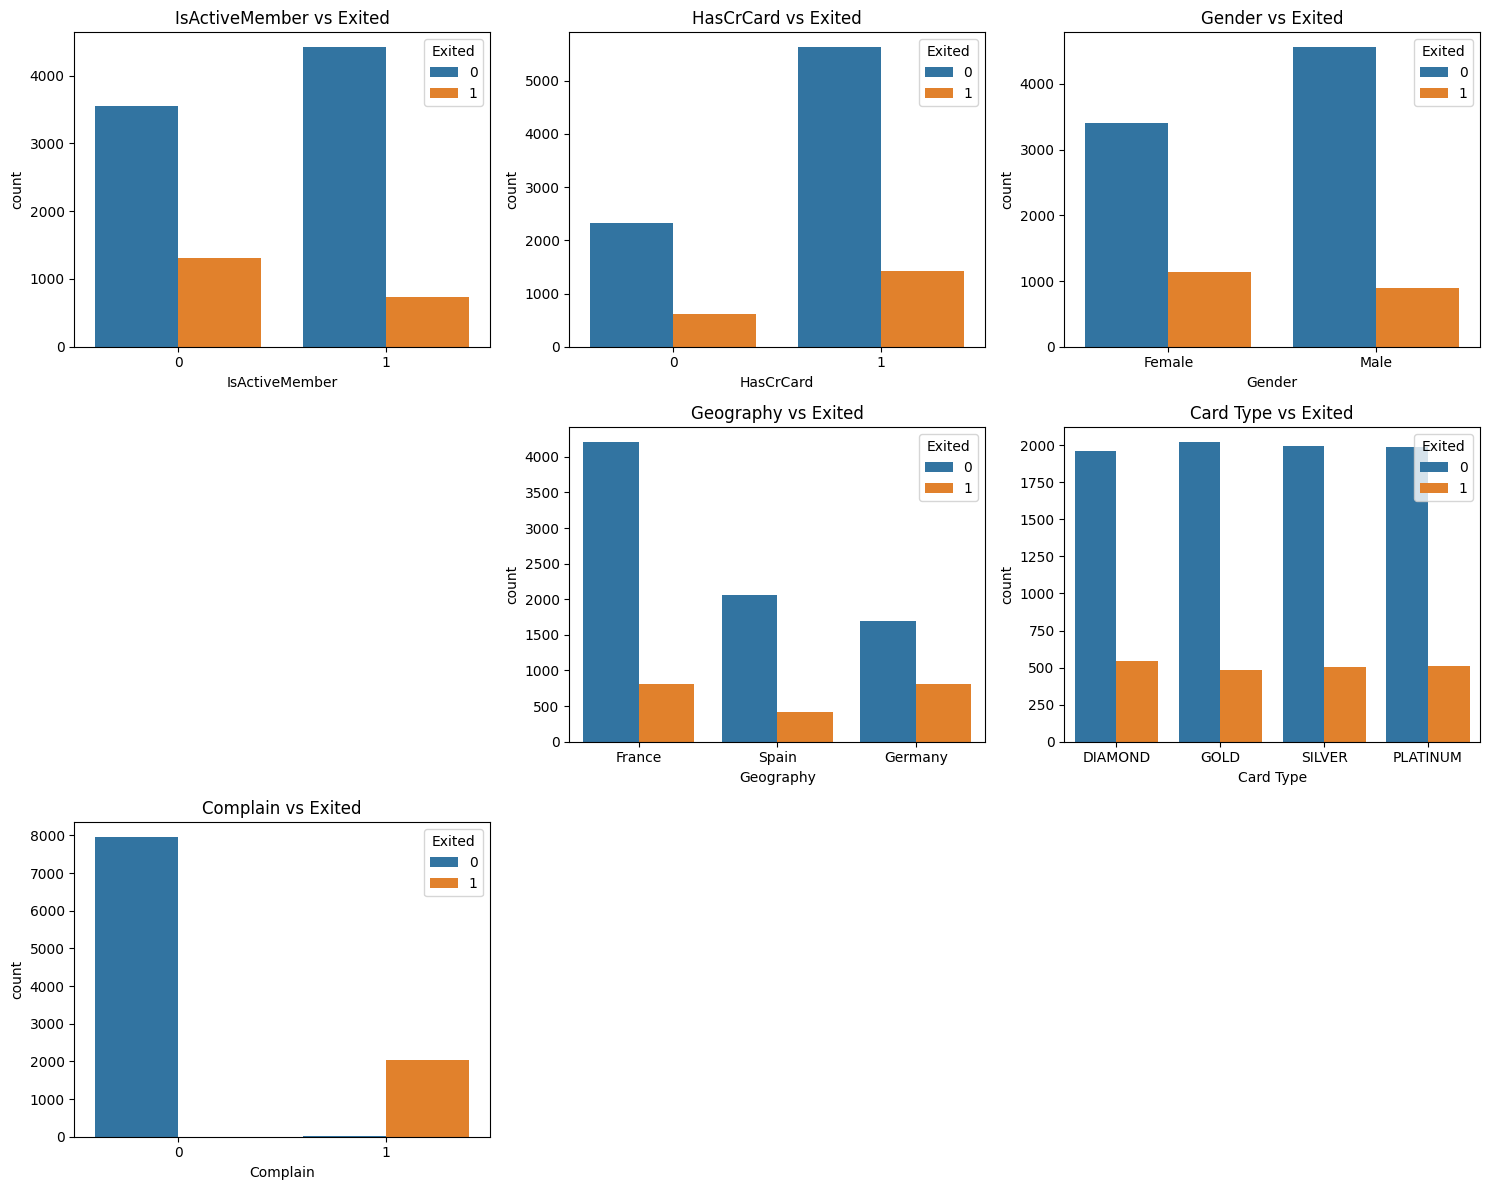

In [14]:
# Configuração do tamanho da figura
plt.figure(figsize=(15, 12))

# Loop para criar os gráficos com a separação por Churn
for i, col in enumerate(var_qualitativas):
    # Pular a própria variável Exited para não ficar redundante
    if col == 'Exited':
        continue

    plt.subplot(3, 3, i + 1)
    # Aqui adicionamos o hue='Exited'
    sns.countplot(data=df_model, x=col, hue='Exited')
    plt.title(f'{col} vs Exited')
    plt.tight_layout()

plt.show()

In [15]:
df_model.groupby('Exited')['Complain'].value_counts()


Exited  Complain
0       0           7952
        1             10
1       1           2034
        0              4
Name: count, dtype: int64

---

#### 📊 Análise das Variáveis Categóricas

---

#### ⭐ **1. Clientes inativos têm maior propensão ao churn**

* Clientes com **IsActiveMember = 0** apresentam uma taxa de churn significativamente maior.
  ➡️ **Inatividade é um forte indicador de risco.**

---

#### ⭐ **2. Possuir cartão de crédito aumenta a chance de saída**

* No grupo que possui **HasCrCard = 1**, observa-se maior proporção de churn comparado aos que não têm cartão.
  ➡️ Pode indicar baixa utilização do produto, oferta inadequada ou benefício pouco relevante.

---

#### ⭐ **3. Mulheres apresentam maior taxa proporcional de churn**

* Embora ambos os gêneros estejam presentes de forma equilibrada, **o churn é proporcionalmente maior entre mulheres**.
  ➡️ Pode sugerir que o banco possua comunicação, serviço ou produtos mais alinhados ao público masculino.

---

#### ⭐ **4. A Alemanha concentra a maior taxa de churn**

* Entre os três países, a **Alemanha apresenta o maior volume proporcional de clientes que saíram**, seguida da França, e a Espanha é a mais estável.
  ➡️ Indica possível diferença regional de experiência, concorrência ou adequação dos produtos.

---

#### ⭐ **5. Tipo de cartão não influencia o churn**

* As categorias **Diamond, Gold, Silver e Platinum** apresentam proporções muito semelhantes de saída.
  ➡️ Portanto, **CardType não é um preditor relevante**.

---

#### ⭐ **6. Reclamações são extremamente associadas ao churn, mas não devem ser usadas no modelo**

* Quase **todos os clientes que reclamaram acabaram saindo**, enquanto praticamente ninguém que ficou registrou reclamação.
* Isso transforma `Complain` em uma variável quase determinística do churn.

##### ❗ Porém, essa variável **não deve ser utilizada** no modelo preditivo:

* **Carrega informação do futuro** — a reclamação ocorre **antes** do churn, mas pode estar muito próxima temporalmente.
* O modelo aprenderia a prever churn apenas porque ocorreu uma reclamação, gerando **data leakage**.
* Isso faria com que o modelo **ignorasse totalmente os sinais que antecedem a insatisfação**.
* O resultado seria um modelo “perfeito”, porém **inútil para prevenção**, pois só detectaria churn após o problema já ter acontecido.

➡️ **Conclusão:** usar `Complain` comprometeria a robustez e a utilidade do modelo.

---

### 🎯 **Resumo Executivo das Variáveis Categóricas**

Os fatores mais relevantes para churn são:

✔ **Inatividade (IsActiveMember = 0)**
✔ **Possuir cartão de crédito**
✔ **Ser mulher**
✔ **Residência na Alemanha**

Fatores com baixo impacto:

✘ **Tipo de cartão**
✘ **Distribuição igualitária em algumas categorias**
✘ **Complain (embora extremamente forte, não pode ser usada)**

---

## Correlações

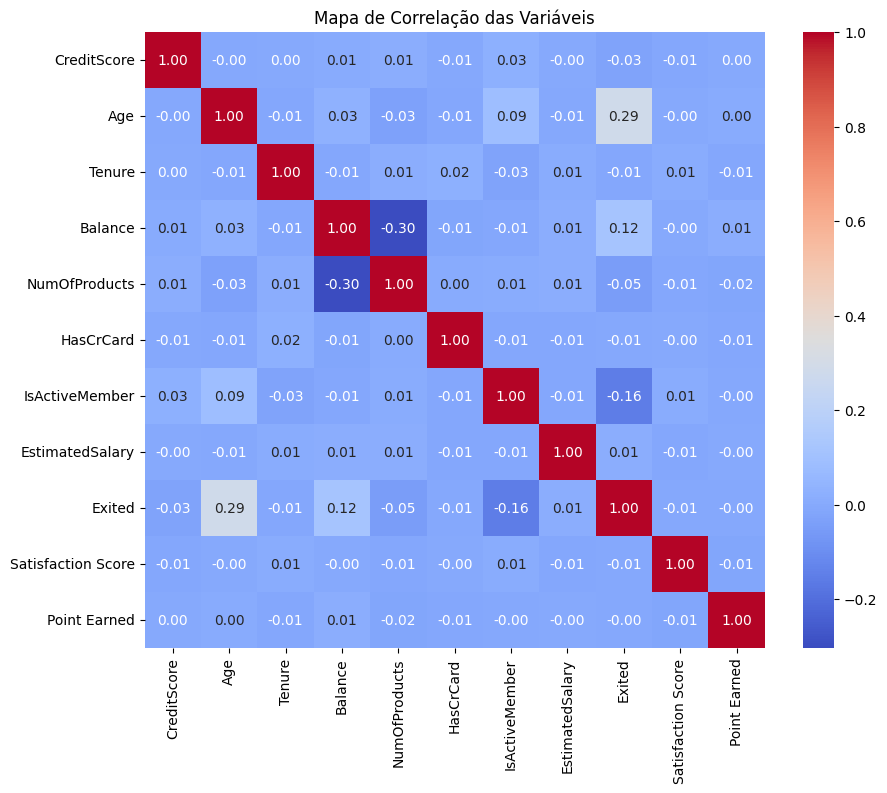

In [16]:
# 1. Removendo a variável com Data Leakage
if 'Complain' in df_model.columns:
    df_model = df_model.drop('Complain', axis=1)

# 2. Gerando a Matriz de Correlação
plt.figure(figsize=(10, 8))
# Selecionando apenas colunas numéricas para a correlação
corr_matrix = df_model.corr(numeric_only=True)

# Plotando o Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlação das Variáveis')
plt.show()

Aqui está um **Markdown no mesmo padrão dos anteriores**, bem organizado, claro e com apenas os **insights realmente significativos do mapa de correlação**, mantendo o estilo profissional e direto.

---

#### 🔗 **Análise do Mapa de Correlação**

---

#### ⭐ **1. Idade tem a correlação mais alta com churn**

* A variável **Age** apresenta correlação **positiva moderada (≈ 0.29)** com `Exited`.
* Clientes mais velhos têm maior probabilidade de sair do banco.
  ➡️ **Idade é um dos preditores mais fortes entre as variáveis disponíveis.**

---

#### ⭐ **2. Clientes ativos têm menor probabilidade de churn**

* A variável **IsActiveMember** apresenta correlação **negativa (-0.16)** com `Exited`.
* Quanto mais ativo o cliente, menor a chance de abandonar o banco.
  ➡️ Ser ativo é um **importante fator de retenção**.

---

#### ⭐ **3. Saldo (Balance) possui correlação levemente positiva com churn**

* `Balance` apresenta correlação **positiva fraca (≈ 0.12)** com `Exited`.
* Clientes com saldos mais altos têm tendência levemente maior a sair, possivelmente:

  * buscando melhores oportunidades financeiras,
  * migrando para bancos com taxas menores,
  * ou utilizando a conta apenas como passagem.
    ➡️ Embora fraca, essa correlação sugere **comportamentos financeiros mais estratégicos** entre clientes com saldo maior.

---

#### ⭐ **4. Número de produtos tem leve correlação negativa com saldo**

* Há uma correlação de **-0.30 entre Balance e NumOfProducts**, indicando que:

  * quem tem mais produtos tende a manter saldos menores,
  * enquanto quem tem poucos produtos tende a manter saldos maiores.
    ➡️ Pode indicar diferentes perfis de uso: clientes “multisserviço” versus clientes “investidores”.

---

#### ⭐ **5. Outras variáveis apresentam correlações muito baixas**

* `CreditScore`, `Tenure`, `HasCrCard`, `EstimatedSalary`, `SatisfactionScore` e `Point Earned` têm correlações próximas de **zero**.
  ➡️ Isoladamente, **não explicam bem o churn**.

---

### 🎯 **Resumo Executivo do Mapa de Correlação**

Os fatores mais correlacionados com churn:

✔ **Idade (correlação positiva moderada)**
✔ **Ser inativo (correlação negativa relevante)**
✔ **Saldo (correlação positiva fraca, mas significativa)**

Variáveis com baixa relevância individual:

✘ **CreditScore**
✘ **Tenure**
✘ **EstimatedSalary**
✘ **HasCrCard**
✘ **SatisfactionScore**
✘ **Point Earned**

---

Se quiser, posso agora **integrar todos os insights quantitativos + categóricos + correlação** em um único relatório final para o notebook.


## Analise Estatistica

In [ ]:
from scipy import stats
import pandas as pd

def realizar_testes_estatisticos(df, target='Exited'):
    print(f"--- Análise Estatística de Impacto no Churn ({target}) ---")

    # 1. Teste para Variáveis Categóricas (Qui-Quadrado)
    cat_vars = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

    print("\n[Variáveis Categóricas - Teste Qui-Quadrado]")
    for col in cat_vars:
        if col in df.columns:
            # Cria tabela de contingência (cruzamento)
            contingency_table = pd.crosstab(df[col], df[target])
            # Calcula o Qui-Quadrado
            chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

            sig = "SIGNIFICANTE " if p_value < 0.05 else "Não Significante "
            print(f"- {col:<15} | p-value: {p_value:.4e} | {sig}")

    # 2. Teste para Variáveis Numéricas (Mann-Whitney)
    num_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

    print("\n[Variáveis Numéricas - Teste Mann-Whitney U]")
    # Separamos os grupos
    group_churn = df[df[target] == 1]
    group_not_churn = df[df[target] == 0]

    for col in num_vars:
        if col in df.columns:
            stat, p_value = stats.mannwhitneyu(group_churn[col], group_not_churn[col])

            sig = "SIGNIFICANTE " if p_value < 0.05 else "Não Significante "
            print(f"- {col:<15} | p-value: {p_value:.4e} | {sig}")

# Chamando a função (use o seu dataframe ANTES do get_dummies)
realizar_testes_estatisticos(df_model)

--- Análise Estatística de Impacto no Churn (Exited) ---

[Variáveis Categóricas - Teste Qui-Quadrado]
- Geography       | p-value: 5.2457e-66 | SIGNIFICANTE ✅
- Gender          | p-value: 2.9254e-26 | SIGNIFICANTE ✅
- HasCrCard       | p-value: 5.0262e-01 | Não Significante ❌
- IsActiveMember  | p-value: 6.1532e-55 | SIGNIFICANTE ✅

[Variáveis Numéricas - Teste Mann-Whitney U]
- CreditScore     | p-value: 2.1751e-02 | SIGNIFICANTE ✅
- Age             | p-value: 2.7803e-230 | SIGNIFICANTE ✅
- Tenure          | p-value: 1.7296e-01 | Não Significante ❌
- Balance         | p-value: 1.1688e-28 | SIGNIFICANTE ✅
- NumOfProducts   | p-value: 7.2794e-36 | SIGNIFICANTE ✅
- EstimatedSalary | p-value: 2.1236e-01 | Não Significante ❌


# Pré-processamento de Dados

Feature Scaling

## Separação de Dataset

In [ ]:
from sklearn.model_selection import train_test_split

X = df_model.drop('Exited', axis=1)
y = df_model['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y,
 test_size=0.3,
 random_state=0,
 stratify=y)
# Uso do Stratify garante que o seu treino e o seu teste mantenham exatamente essa mesma proporção. Sem isso, você poderia ter o azar de o teste ficar só com clientes que "Ficaram", o que mascararia a performance real do modelo

## Modelagem

#### Configuracao de MOdelos

In [19]:
models_default = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "NeuralNetwork": MLPClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
}

#### Configuracao de paramentros

In [20]:
param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [500, 1000]
    },
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    "DecisionTree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "NeuralNetwork": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001]
    },
     "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

}


resultados = []

In [ ]:
def garantir_duas_colunas(scores):
    scores = np.array(scores)

    # Caso já tenha 2 colunas
    if scores.ndim == 2 and scores.shape[1] == 2:
        return scores

    # Caso seja 1D — binário
    if scores.ndim == 1:
        # Normalizar para [0,1]
        min_v = scores.min()
        max_v = scores.max()
        if max_v - min_v == 0:
            score_pos = np.zeros_like(scores)
        else:
            score_pos = (scores - min_v) / (max_v - min_v)

        score_neg = 1 - score_pos
        return np.vstack([score_neg, score_pos]).T

    # Caso seja 2D porém só com 1 coluna
    if scores.ndim == 2 and scores.shape[1] == 1:
        col = scores[:, 0]
        min_v = col.min()
        max_v = col.max()
        if max_v - min_v == 0:
            score_pos = np.zeros_like(col)
        else:
            score_pos = (col - min_v) / (max_v - min_v)

        score_neg = 1 - score_pos
        return np.vstack([score_neg, score_pos]).T


#### Classe ModelTrainer

In [ ]:
import os
import time
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

class ModelTrainer:
    def __init__(self, X_train, y_train, X_test, y_test, models, num_features, cat_features, param_grids=None, best_params=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.models = models
        self.num_features = num_features
        self.cat_features = cat_features
        
        self.param_grids = param_grids if param_grids else {}
        self.best_params = best_params if best_params else {}
        self.results = []
        
        self.best_model_info = {
            "pipeline": None,
            "name": "",
            "score": 0.0,
            "metric": ""
        }

    def _get_metric_score(self, y_true, y_pred, metric_name):
        if metric_name == 'accuracy':
            return accuracy_score(y_true, y_pred)
        elif metric_name == 'recall':
            return recall_score(y_true, y_pred, average='macro')
        elif metric_name == 'recall_1':
            return recall_score(y_true, y_pred, pos_label=1, average='binary')
        elif metric_name == 'precision':
            return precision_score(y_true, y_pred, average='macro')
        elif metric_name == 'f1':
            return f1_score(y_true, y_pred, average='macro')
        else:
            raise ValueError(f"Métrica '{metric_name}' não suportada.")

    def _build_pipeline(self, model, balanceamento, usar_pca, usar_scaler):
        """Constrói a pipeline completa com Pré-proc -> Resample -> PCA -> Modelo"""
        
        steps = []

        # 1. PRÉ-PROCESSAMENTO (ColumnTransformer)
        numeric_transformer = StandardScaler() if usar_scaler else 'passthrough'
        
        categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.num_features),
                ('cat', categorical_transformer, self.cat_features)
            ],
            verbose_feature_names_out=False
        )
        
        steps.append(('preprocessor', preprocessor))

        # 2. BALANCEAMENTO 
        if balanceamento == "SMOTE":
            steps.append(('balancing', SMOTE(random_state=42)))
        elif balanceamento == "TomekLinks":
            steps.append(('balancing', TomekLinks()))

        # 3. PCA
        if usar_pca:
            steps.append(('pca', PCA(n_components=0.95)))

        # 4. MODELO
        steps.append(('model', model))

        return ImbPipeline(steps)

    def train(self, metric_optimize='recall_1', balanceamento=None, usar_pca=False, usar_scaler=True, tipo_parametros='default', salvar_parametros=True, path_salvar = os.path.join(os.getcwd(), "resultados_treino")):

        if not os.path.exists(path_salvar):
            os.makedirs(path_salvar)

        self.results = []
        self.best_model_info = {"pipeline": None, "name": "", "score": 0.0, "metric": metric_optimize}

        print(f"🚀 Iniciando treinamento otimizando por: {metric_optimize.upper()}\n")

        for name, model in self.models.items():
            print(f"\n{'='*20} {name} {'='*20}")

            # Constrói o pipeline base
            pipeline = self._build_pipeline(model, balanceamento, usar_pca, usar_scaler)

            # --- Lógica de Grid Search ---
            if tipo_parametros == "grid" and name in self.param_grids:
                params = self.param_grids[name]
                pipeline_params = {f'model__{k}': v for k, v in params.items()}
                
                scoring_map = {'accuracy': 'accuracy', 'recall': 'recall_macro', 'recall_1': 'recall', 'precision': 'precision_macro', 'f1': 'f1_macro'}
                
                estimator = GridSearchCV(estimator=pipeline, param_grid=pipeline_params, cv=5, n_jobs=-1, scoring=scoring_map.get(metric_optimize, 'accuracy'), verbose=1)
            
            elif tipo_parametros == "best" and name in self.best_params:
                params = self.best_params[name]
                model.set_params(**params)
                estimator = self._build_pipeline(model, balanceamento, usar_pca, usar_scaler)
            
            else:
                estimator = pipeline

            # --- Treinamento ---
            inicio = time.time()
            estimator.fit(self.X_train, self.y_train)
            fim = time.time()
            tempo_treino = fim - inicio

            # --- Predição ---
            y_pred = estimator.predict(self.X_test)
            score_atual = self._get_metric_score(self.y_test, y_pred, metric_optimize)

            # --- Métricas e Visualização ---
            acc = accuracy_score(self.y_test, y_pred)
            rec_class_1 = recall_score(self.y_test, y_pred, pos_label=1, average='binary')

            classes = unique_labels(self.y_test, y_pred)
            target_names = [f"Classe {c}" for c in classes]

            print(f"Relatório para {name}:")
            print(classification_report(self.y_test, y_pred, target_names=target_names))

            cm = confusion_matrix(self.y_test, y_pred, labels=classes)
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
            plt.title(f'Matriz de Confusão - {name}')
            plt.show()

            # --- Salvar Melhor Modelo ---
            if score_atual > self.best_model_info["score"]:
                print(f"✨ Novo Recorde! {name} com {metric_optimize}: {score_atual:.4f}")
                self.best_model_info["score"] = score_atual
                self.best_model_info["name"] = name
                
                if hasattr(estimator, 'best_estimator_'):
                    self.best_model_info["pipeline"] = estimator.best_estimator_
                    best_params_found = estimator.best_params_
                else:
                    self.best_model_info["pipeline"] = estimator
                    best_params_found = "Default"

            else:
                best_params_found = "Ignorado"

            self.results.append({
                "Modelo": name,
                "Config": f"Bal:{balanceamento}|PCA:{usar_pca}|Scl:{usar_scaler}",
                f"Score ({metric_optimize})": score_atual,
                "Recall (1)": rec_class_1,
                "Acurácia": acc,
                "Tempo": tempo_treino,
                "Params": best_params_found
            })

            if salvar_parametros and isinstance(best_params_found, dict):
                 clean_params = {k.replace('model__', ''): v for k, v in best_params_found.items()}
                 try: joblib.dump(clean_params, f'{path_salvar}/parametros_{name}.pkl')
                 except: pass

            print("=" * 52)

        self._final_report(path_salvar)
        return self.best_model_info["pipeline"]

    def _final_report(self, path_salvar):
        df = pd.DataFrame(self.results).sort_values(by=f"Score ({self.best_model_info['metric']})", ascending=False)
        print("\n🏆 Resultados:")
        try:
            from IPython.display import display
            display(df)
        except:
            print(df)

        if self.best_model_info["pipeline"]:
            nome_modelo = self.best_model_info["name"]
            nome_arquivo = f'{path_salvar}/{nome_modelo}_PIPELINE_COMPLETO.pkl'
            joblib.dump(self.best_model_info["pipeline"], nome_arquivo)
            print(f"\n💾 Pipeline COMPLETO salvo em: {nome_arquivo}")
            print("   -> Este arquivo está pronto para uso no Streamlit!")

Pipleine

In [ ]:
models_best_parameters={}

NUM_COLS = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Point Earned']
CAT_COLS = ['Geography', 'Gender', 'Card Type', 'HasCrCard', 'IsActiveMember']

trainer = ModelTrainer(
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    models=models_default, 
    num_features=NUM_COLS,
    cat_features=CAT_COLS 
)

Cenarios

🚀 Iniciando bateria de testes com 15 cenários...


>>> 🧪 Testando Cenário: Default
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.97      0.89      2389
    Classe 1       0.60      0.20      0.30       611

    accuracy                           0.81      3000
   macro avg       0.71      0.58      0.60      3000
weighted avg       0.78      0.81      0.77      3000



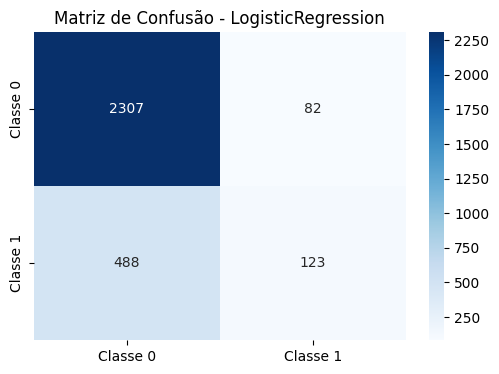

✨ Novo Recorde! LogisticRegression com recall_1: 0.2013

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.75      0.42      0.54       611

    accuracy                           0.85      3000
   macro avg       0.81      0.69      0.73      3000
weighted avg       0.84      0.85      0.84      3000



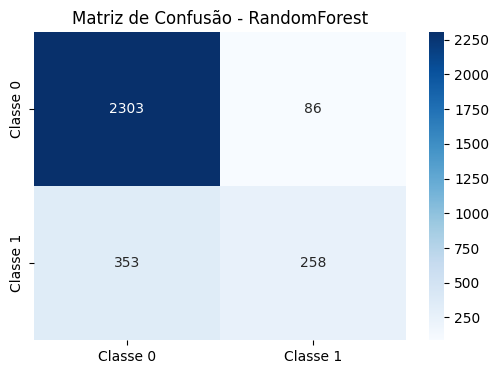

✨ Novo Recorde! RandomForest com recall_1: 0.4223

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.85      0.98      0.91      2389
    Classe 1       0.81      0.35      0.49       611

    accuracy                           0.85      3000
   macro avg       0.83      0.66      0.70      3000
weighted avg       0.85      0.85      0.83      3000



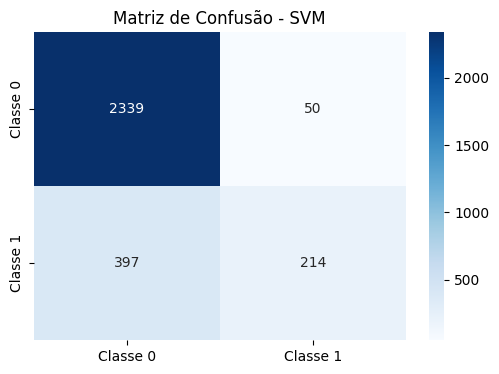


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.85      0.95      0.90      2389
    Classe 1       0.62      0.35      0.45       611

    accuracy                           0.82      3000
   macro avg       0.74      0.65      0.67      3000
weighted avg       0.80      0.82      0.80      3000



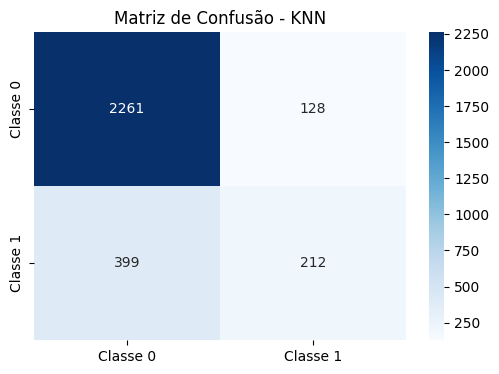


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.86      0.87      2389
    Classe 1       0.47      0.47      0.47       611

    accuracy                           0.79      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.79      0.79      0.79      3000



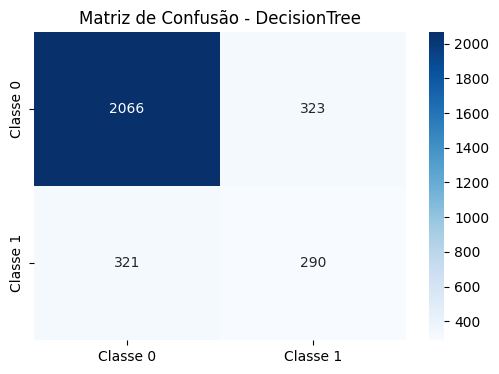

✨ Novo Recorde! DecisionTree com recall_1: 0.4746

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.72      0.44      0.55       611

    accuracy                           0.85      3000
   macro avg       0.80      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


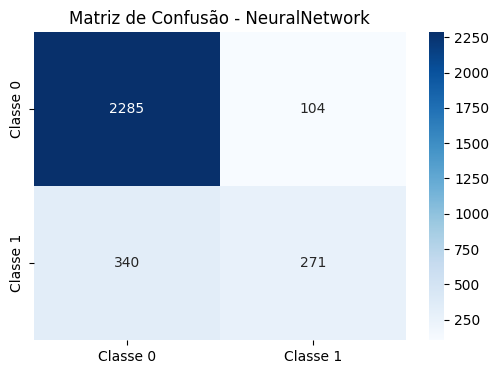


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.66      0.46      0.54       611

    accuracy                           0.84      3000
   macro avg       0.76      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



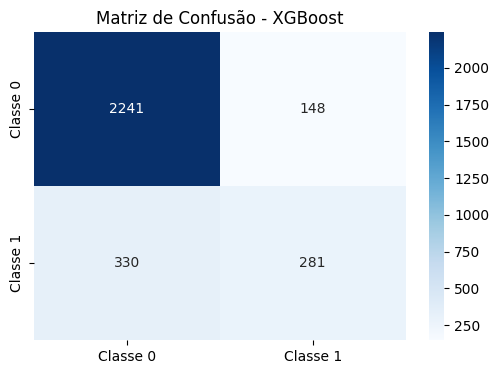


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.66      0.45      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



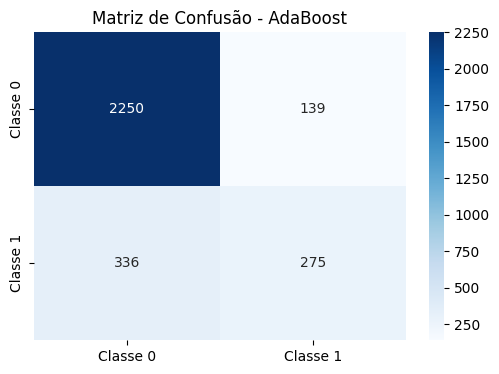


🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
4        DecisionTree  Bal:None|PCA:False|Scl:True          0.474632   
6             XGBoost  Bal:None|PCA:False|Scl:True          0.459902   
7            AdaBoost  Bal:None|PCA:False|Scl:True          0.450082   
5       NeuralNetwork  Bal:None|PCA:False|Scl:True          0.443535   
1        RandomForest  Bal:None|PCA:False|Scl:True          0.422259   
2                 SVM  Bal:None|PCA:False|Scl:True          0.350245   
3                 KNN  Bal:None|PCA:False|Scl:True          0.346972   
0  LogisticRegression  Bal:None|PCA:False|Scl:True          0.201309   

   Recall (1)  Acurácia     Tempo    Params  
4    0.474632  0.785333  0.084913   Default  
6    0.459902  0.840667  0.440377  Ignorado  
7    0.450082  0.841667  0.416555  Ignorado  
5    0.443535  0.852000  4.585739  Ignorado  
1    0.422259  0.853667  1.711470   Default  
2    0.350245  0.851000  0.777699  Ignorado  
3    0.346972  0.824333  0.019199  Ignorado  
0    0.201309  0.810000  0.048555   Default


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Default + SMOTE
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.89      0.71      0.79      2389
    Classe 1       0.38      0.67      0.48       611

    accuracy                           0.71      3000
   macro avg       0.64      0.69      0.64      3000
weighted avg       0.79      0.71      0.73      3000



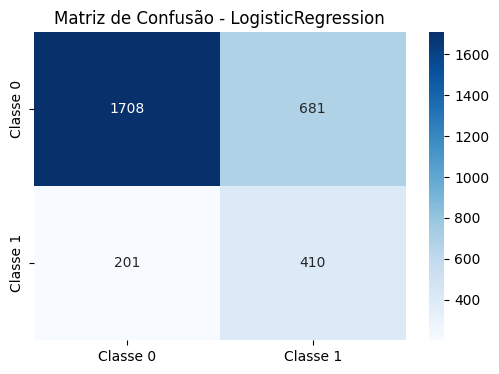

✨ Novo Recorde! LogisticRegression com recall_1: 0.6710

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.88      0.94      0.91      2389
    Classe 1       0.66      0.48      0.56       611

    accuracy                           0.84      3000
   macro avg       0.77      0.71      0.73      3000
weighted avg       0.83      0.84      0.84      3000



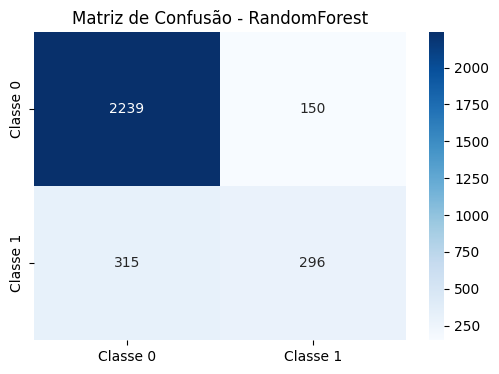


==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.90      0.84      0.87      2389
    Classe 1       0.51      0.64      0.57       611

    accuracy                           0.80      3000
   macro avg       0.71      0.74      0.72      3000
weighted avg       0.82      0.80      0.81      3000



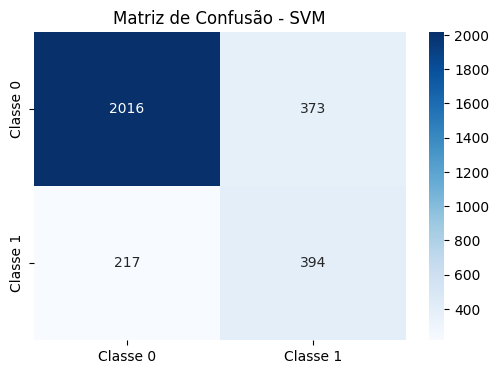


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.89      0.74      0.81      2389
    Classe 1       0.39      0.66      0.49       611

    accuracy                           0.72      3000
   macro avg       0.64      0.70      0.65      3000
weighted avg       0.79      0.72      0.74      3000



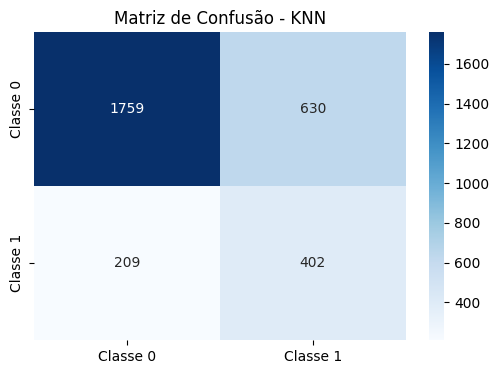


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.84      0.86      2389
    Classe 1       0.45      0.53      0.49       611

    accuracy                           0.77      3000
   macro avg       0.66      0.68      0.67      3000
weighted avg       0.79      0.77      0.78      3000



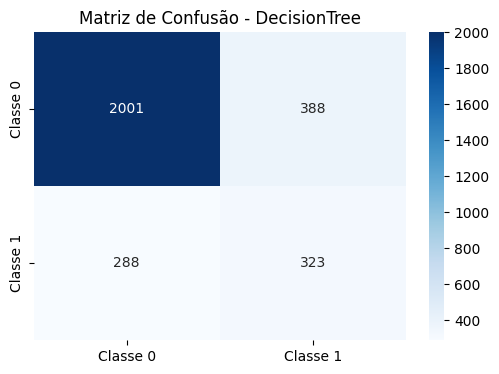


==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.88      0.88      2389
    Classe 1       0.53      0.53      0.53       611

    accuracy                           0.81      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.81      0.81      0.81      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


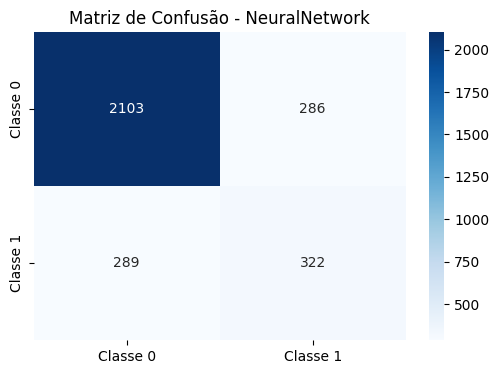


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.94      0.91      2389
    Classe 1       0.68      0.48      0.56       611

    accuracy                           0.85      3000
   macro avg       0.78      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000



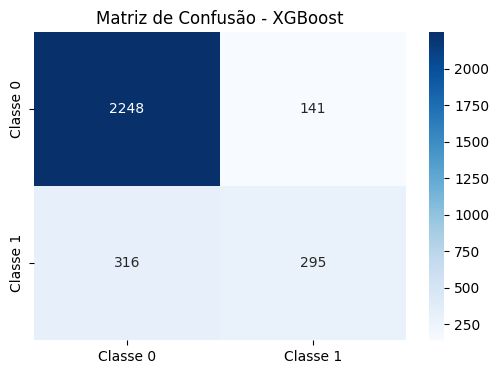


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.90      0.83      0.86      2389
    Classe 1       0.49      0.65      0.56       611

    accuracy                           0.79      3000
   macro avg       0.70      0.74      0.71      3000
weighted avg       0.82      0.79      0.80      3000



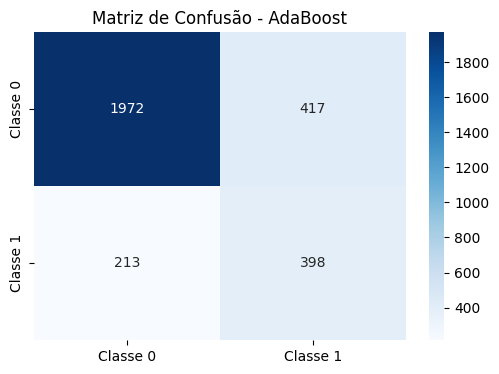


🏆 Resultados:


Modelo                        Config  Score (recall_1)  \
0  LogisticRegression  Bal:SMOTE|PCA:False|Scl:True          0.671031   
3                 KNN  Bal:SMOTE|PCA:False|Scl:True          0.657938   
7            AdaBoost  Bal:SMOTE|PCA:False|Scl:True          0.651391   
2                 SVM  Bal:SMOTE|PCA:False|Scl:True          0.644845   
4        DecisionTree  Bal:SMOTE|PCA:False|Scl:True          0.528642   
5       NeuralNetwork  Bal:SMOTE|PCA:False|Scl:True          0.527005   
1        RandomForest  Bal:SMOTE|PCA:False|Scl:True          0.484452   
6             XGBoost  Bal:SMOTE|PCA:False|Scl:True          0.482815   

   Recall (1)  Acurácia     Tempo    Params  
0    0.671031  0.706000  0.218585   Default  
3    0.657938  0.720333  0.177842  Ignorado  
7    0.651391  0.790000  0.842193  Ignorado  
2    0.644845  0.803333  2.473100  Ignorado  
4    0.528642  0.774667  0.314509  Ignorado  
5    0.527005  0.808333  6.558942  Ignorado  
1    0.484452  0.845000  2.464309  Ignorado  
6    0.482815  0.847667  0.645343  Ignorado


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/LogisticRegression_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Default + Tomek
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.96      0.89      2389
    Classe 1       0.58      0.24      0.34       611

    accuracy                           0.81      3000
   macro avg       0.71      0.60      0.61      3000
weighted avg       0.78      0.81      0.78      3000



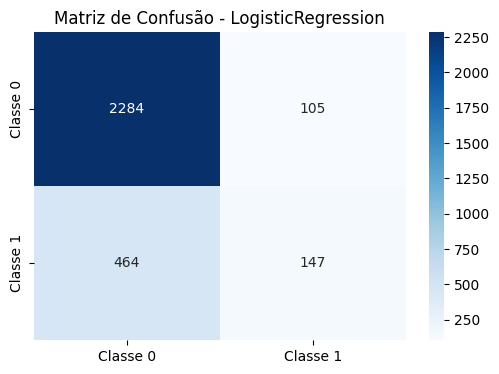

✨ Novo Recorde! LogisticRegression com recall_1: 0.2406

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2389
    Classe 1       0.73      0.47      0.57       611

    accuracy                           0.86      3000
   macro avg       0.80      0.71      0.74      3000
weighted avg       0.84      0.86      0.84      3000



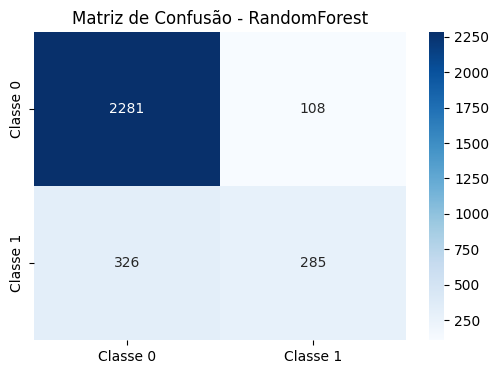

✨ Novo Recorde! RandomForest com recall_1: 0.4664

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.75      0.42      0.54       611

    accuracy                           0.85      3000
   macro avg       0.81      0.69      0.73      3000
weighted avg       0.84      0.85      0.84      3000



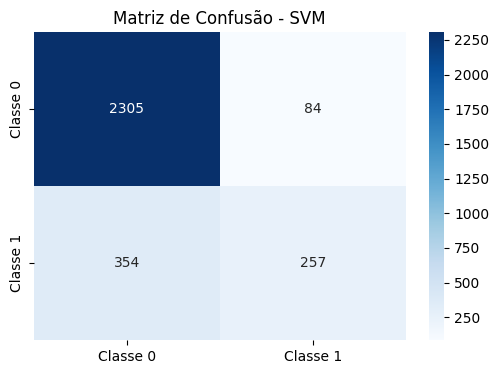


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.86      0.94      0.89      2389
    Classe 1       0.61      0.38      0.47       611

    accuracy                           0.82      3000
   macro avg       0.73      0.66      0.68      3000
weighted avg       0.80      0.82      0.81      3000



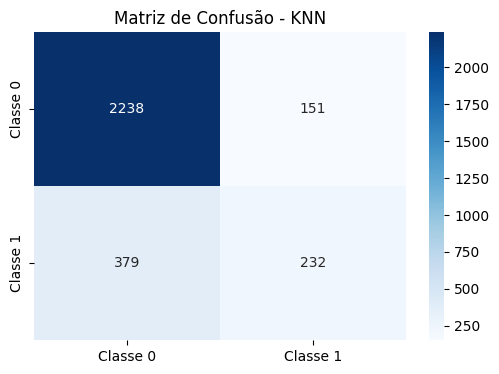


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.85      0.86      2389
    Classe 1       0.47      0.52      0.49       611

    accuracy                           0.78      3000
   macro avg       0.67      0.69      0.68      3000
weighted avg       0.79      0.78      0.79      3000



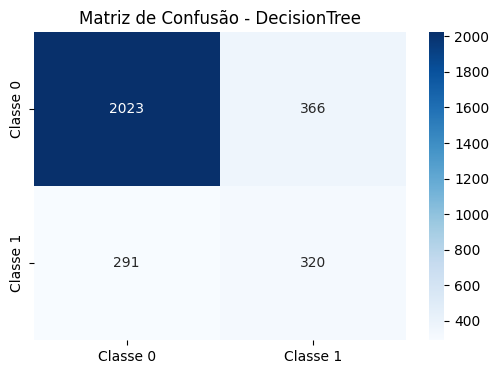

✨ Novo Recorde! DecisionTree com recall_1: 0.5237

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.94      0.91      2389
    Classe 1       0.67      0.48      0.56       611

    accuracy                           0.85      3000
   macro avg       0.78      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


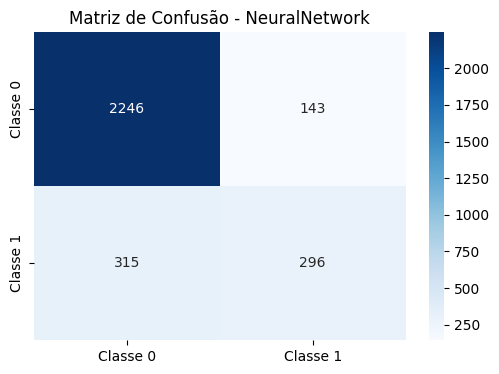


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.63      0.49      0.55       611

    accuracy                           0.84      3000
   macro avg       0.75      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000



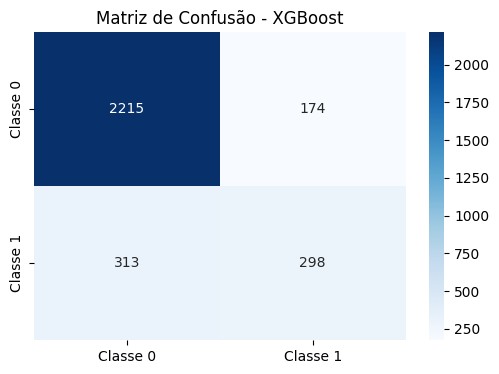


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.64      0.48      0.55       611

    accuracy                           0.84      3000
   macro avg       0.76      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000



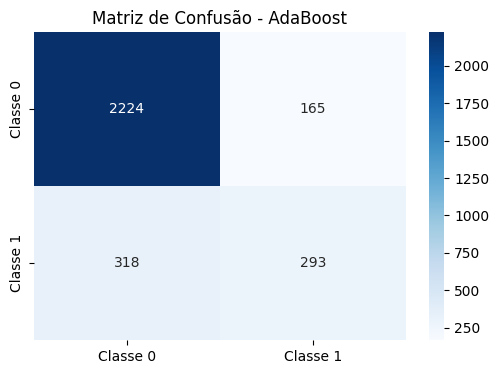


🏆 Resultados:


Modelo                             Config  Score (recall_1)  \
4        DecisionTree  Bal:TomekLinks|PCA:False|Scl:True          0.523732   
6             XGBoost  Bal:TomekLinks|PCA:False|Scl:True          0.487725   
5       NeuralNetwork  Bal:TomekLinks|PCA:False|Scl:True          0.484452   
7            AdaBoost  Bal:TomekLinks|PCA:False|Scl:True          0.479542   
1        RandomForest  Bal:TomekLinks|PCA:False|Scl:True          0.466448   
2                 SVM  Bal:TomekLinks|PCA:False|Scl:True          0.420622   
3                 KNN  Bal:TomekLinks|PCA:False|Scl:True          0.379705   
0  LogisticRegression  Bal:TomekLinks|PCA:False|Scl:True          0.240589   

   Recall (1)  Acurácia     Tempo    Params  
4    0.523732  0.781000  0.229398   Default  
6    0.487725  0.837667  0.539307  Ignorado  
5    0.484452  0.847333  3.801286  Ignorado  
7    0.479542  0.839000  0.510022  Ignorado  
1    0.466448  0.855333  1.372362   Default  
2    0.420622  0.854000  0.763527  Ignorado  
3    0.379705  0.823333  0.115091  Ignorado  
0    0.240589  0.810333  0.150945   Default


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Default + PCA + SMOTE
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.90      0.72      0.80      2389
    Classe 1       0.38      0.68      0.49       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000



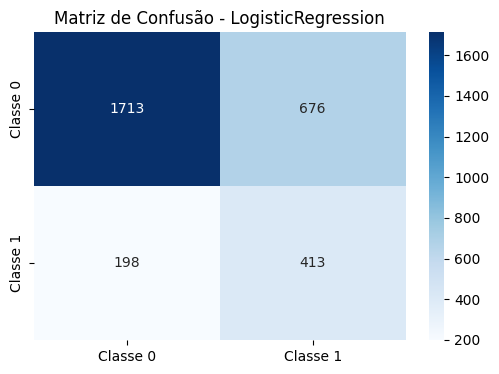

✨ Novo Recorde! LogisticRegression com recall_1: 0.6759

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.88      0.90      0.89      2389
    Classe 1       0.56      0.52      0.54       611

    accuracy                           0.82      3000
   macro avg       0.72      0.71      0.71      3000
weighted avg       0.82      0.82      0.82      3000



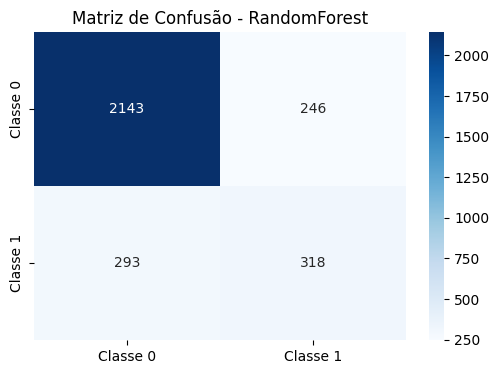


==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.90      0.85      0.87      2389
    Classe 1       0.52      0.65      0.58       611

    accuracy                           0.81      3000
   macro avg       0.71      0.75      0.72      3000
weighted avg       0.83      0.81      0.81      3000



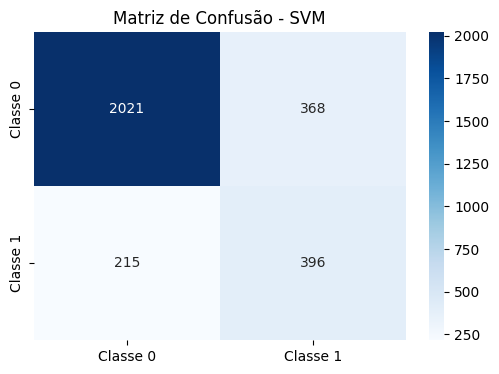


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.89      0.73      0.80      2389
    Classe 1       0.38      0.64      0.48       611

    accuracy                           0.71      3000
   macro avg       0.63      0.69      0.64      3000
weighted avg       0.78      0.71      0.74      3000



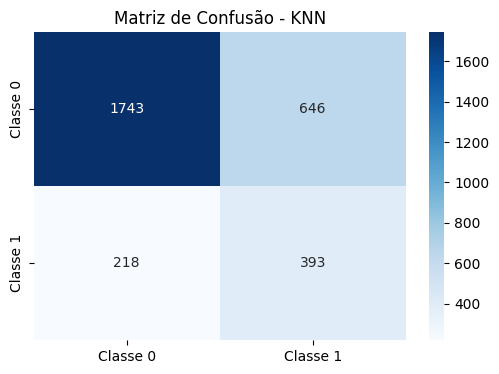


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.80      0.83      2389
    Classe 1       0.40      0.51      0.45       611

    accuracy                           0.74      3000
   macro avg       0.63      0.66      0.64      3000
weighted avg       0.77      0.74      0.75      3000



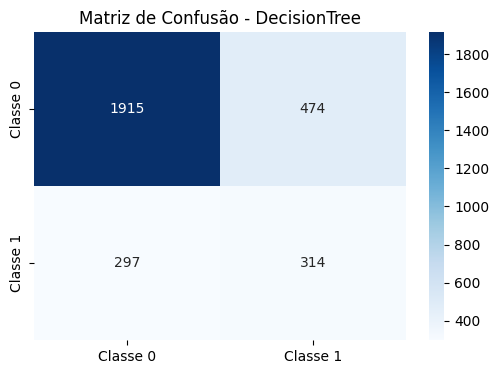


==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.89      0.86      0.88      2389
    Classe 1       0.52      0.60      0.56       611

    accuracy                           0.81      3000
   macro avg       0.71      0.73      0.72      3000
weighted avg       0.82      0.81      0.81      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


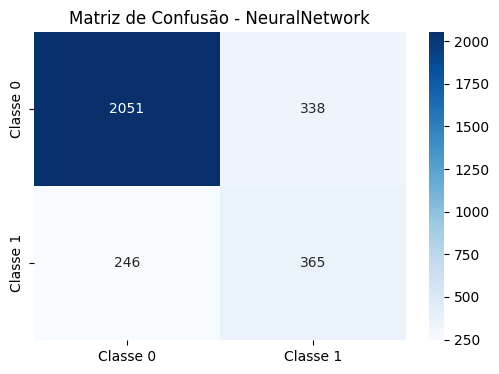


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.89      0.87      0.88      2389
    Classe 1       0.53      0.57      0.55       611

    accuracy                           0.81      3000
   macro avg       0.71      0.72      0.72      3000
weighted avg       0.82      0.81      0.81      3000



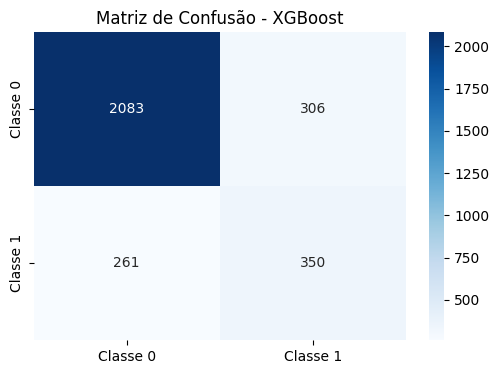


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.91      0.76      0.83      2389
    Classe 1       0.42      0.70      0.53       611

    accuracy                           0.74      3000
   macro avg       0.67      0.73      0.68      3000
weighted avg       0.81      0.74      0.76      3000



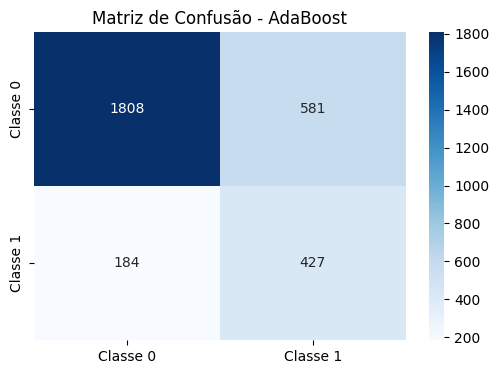

✨ Novo Recorde! AdaBoost com recall_1: 0.6989

🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
7            AdaBoost  Bal:SMOTE|PCA:True|Scl:True          0.698854   
0  LogisticRegression  Bal:SMOTE|PCA:True|Scl:True          0.675941   
2                 SVM  Bal:SMOTE|PCA:True|Scl:True          0.648118   
3                 KNN  Bal:SMOTE|PCA:True|Scl:True          0.643208   
5       NeuralNetwork  Bal:SMOTE|PCA:True|Scl:True          0.597381   
6             XGBoost  Bal:SMOTE|PCA:True|Scl:True          0.572831   
1        RandomForest  Bal:SMOTE|PCA:True|Scl:True          0.520458   
4        DecisionTree  Bal:SMOTE|PCA:True|Scl:True          0.513912   

   Recall (1)  Acurácia     Tempo    Params  
7    0.698854  0.745000  1.535651   Default  
0    0.675941  0.708667  0.174802   Default  
2    0.648118  0.805667  2.418396  Ignorado  
3    0.643208  0.712000  0.212079  Ignorado  
5    0.597381  0.805333  6.279056  Ignorado  
6    0.572831  0.811000  0.624264  Ignorado  
1    0.520458  0.820333  4.167451  Ignorado  
4    0.513912  0.743000  0.462940  Ignorado


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/AdaBoost_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Default + PCA + Tomek
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.95      0.89      2389
    Classe 1       0.54      0.22      0.31       611

    accuracy                           0.80      3000
   macro avg       0.68      0.59      0.60      3000
weighted avg       0.77      0.80      0.77      3000



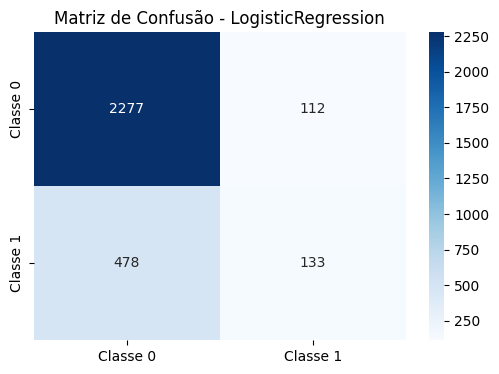

✨ Novo Recorde! LogisticRegression com recall_1: 0.2177

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.71      0.39      0.50       611

    accuracy                           0.84      3000
   macro avg       0.78      0.67      0.70      3000
weighted avg       0.83      0.84      0.82      3000



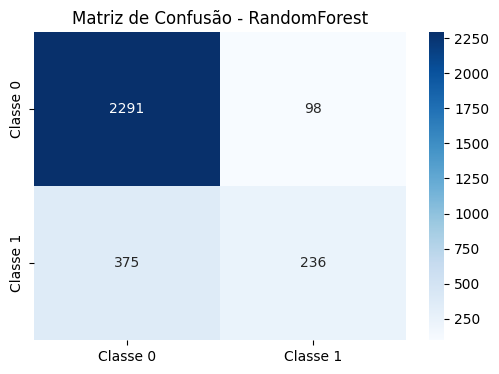

✨ Novo Recorde! RandomForest com recall_1: 0.3863

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.74      0.39      0.51       611

    accuracy                           0.85      3000
   macro avg       0.80      0.68      0.71      3000
weighted avg       0.84      0.85      0.83      3000



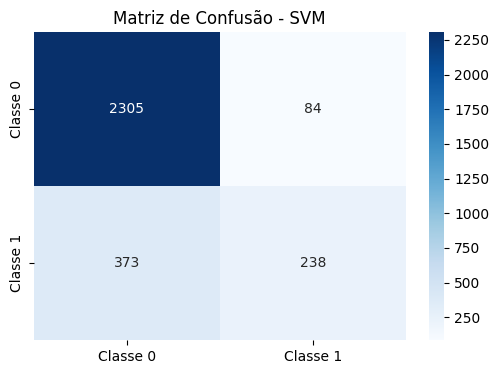

✨ Novo Recorde! SVM com recall_1: 0.3895

==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.86      0.93      0.89      2389
    Classe 1       0.60      0.39      0.47       611

    accuracy                           0.82      3000
   macro avg       0.73      0.66      0.68      3000
weighted avg       0.80      0.82      0.81      3000



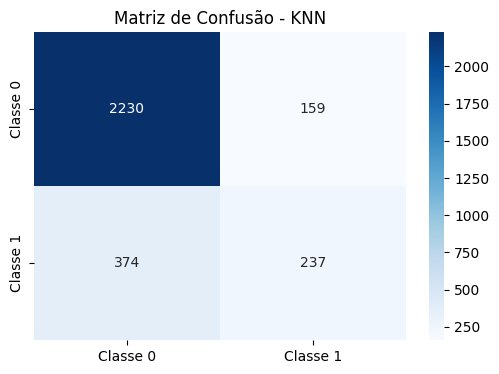


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.84      0.86      2389
    Classe 1       0.46      0.51      0.48       611

    accuracy                           0.78      3000
   macro avg       0.66      0.68      0.67      3000
weighted avg       0.79      0.78      0.78      3000



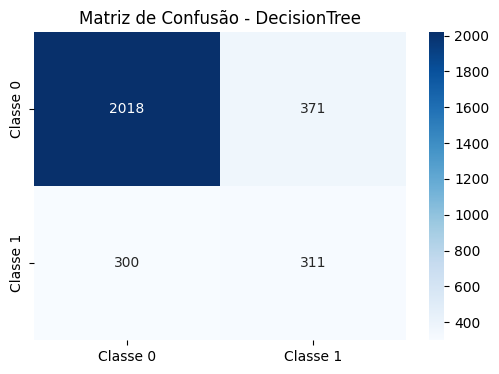

✨ Novo Recorde! DecisionTree com recall_1: 0.5090

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.91      2389
    Classe 1       0.67      0.45      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.69      0.72      3000
weighted avg       0.83      0.84      0.83      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


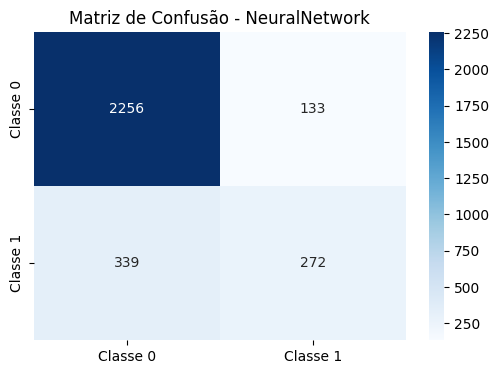


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.63      0.46      0.53       611

    accuracy                           0.84      3000
   macro avg       0.75      0.69      0.72      3000
weighted avg       0.82      0.84      0.83      3000



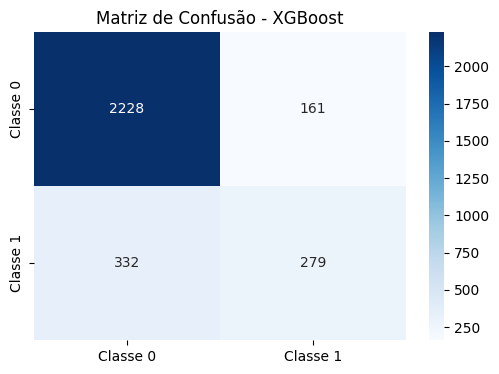


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.84      0.96      0.90      2389
    Classe 1       0.66      0.28      0.39       611

    accuracy                           0.82      3000
   macro avg       0.75      0.62      0.65      3000
weighted avg       0.80      0.82      0.79      3000



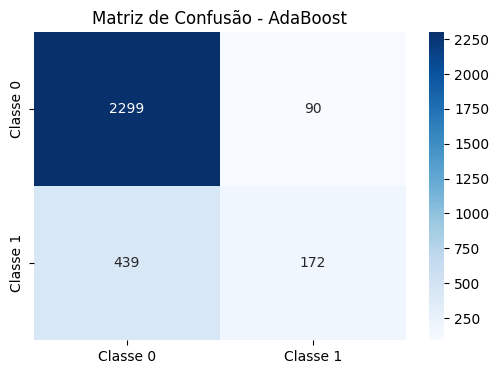


🏆 Resultados:


Modelo                            Config  Score (recall_1)  \
4        DecisionTree  Bal:TomekLinks|PCA:True|Scl:True          0.509002   
6             XGBoost  Bal:TomekLinks|PCA:True|Scl:True          0.456628   
5       NeuralNetwork  Bal:TomekLinks|PCA:True|Scl:True          0.445172   
2                 SVM  Bal:TomekLinks|PCA:True|Scl:True          0.389525   
3                 KNN  Bal:TomekLinks|PCA:True|Scl:True          0.387889   
1        RandomForest  Bal:TomekLinks|PCA:True|Scl:True          0.386252   
7            AdaBoost  Bal:TomekLinks|PCA:True|Scl:True          0.281506   
0  LogisticRegression  Bal:TomekLinks|PCA:True|Scl:True          0.217676   

   Recall (1)  Acurácia     Tempo    Params  
4    0.509002  0.776333  0.356602   Default  
6    0.456628  0.835667  0.550927  Ignorado  
5    0.445172  0.842667  3.864991  Ignorado  
2    0.389525  0.847667  0.786221   Default  
3    0.387889  0.822333  0.148825  Ignorado  
1    0.386252  0.842333  2.731797   Default  
7    0.281506  0.823667  0.961173  Ignorado  
0    0.217676  0.803333  0.137629   Default


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Grid
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.97      0.89      2389
    Classe 1       0.60      0.20      0.30       611

    accuracy                           0.81      3000
   macro avg       0.71      0.58      0.60      3000
weighted avg       0.78      0.81      0.77      3000



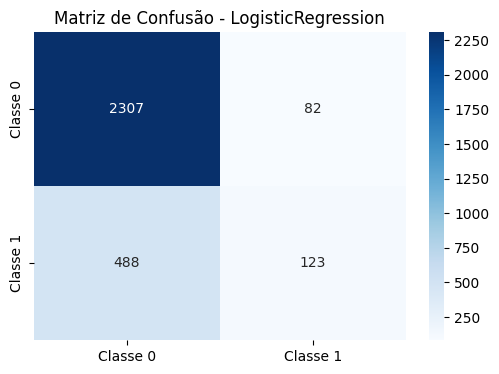

✨ Novo Recorde! LogisticRegression com recall_1: 0.2013

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.97      0.92      2389
    Classe 1       0.77      0.42      0.55       611

    accuracy                           0.86      3000
   macro avg       0.82      0.70      0.73      3000
weighted avg       0.85      0.86      0.84      3000



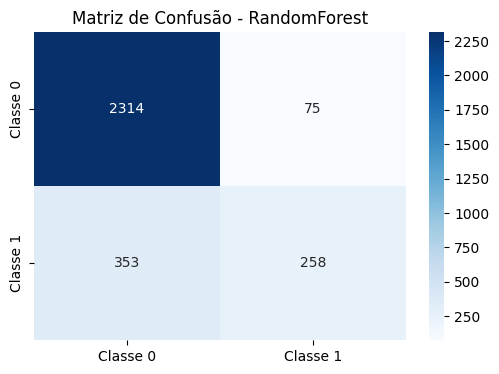

✨ Novo Recorde! RandomForest com recall_1: 0.4223

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.85      0.98      0.91      2389
    Classe 1       0.81      0.35      0.49       611

    accuracy                           0.85      3000
   macro avg       0.83      0.66      0.70      3000
weighted avg       0.85      0.85      0.83      3000



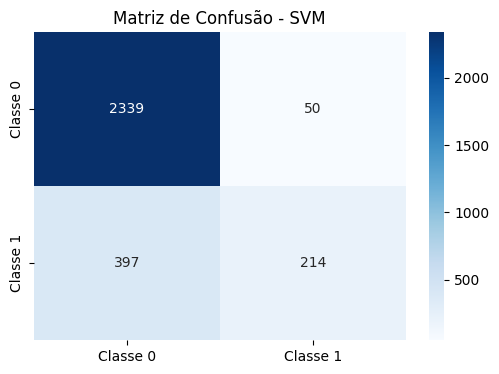


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.85      0.95      0.90      2389
    Classe 1       0.62      0.35      0.45       611

    accuracy                           0.82      3000
   macro avg       0.74      0.65      0.67      3000
weighted avg       0.80      0.82      0.80      3000



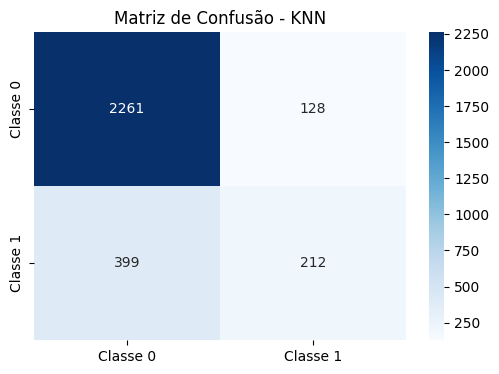


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.86      0.86      2389
    Classe 1       0.46      0.48      0.47       611

    accuracy                           0.78      3000
   macro avg       0.66      0.67      0.67      3000
weighted avg       0.78      0.78      0.78      3000



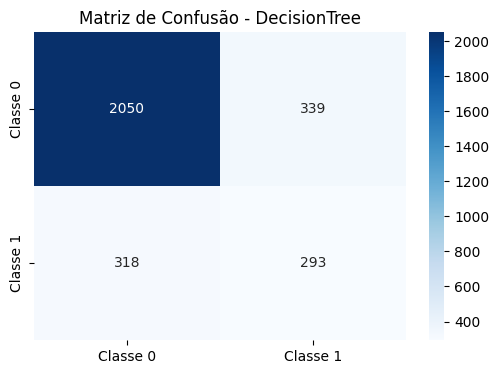

✨ Novo Recorde! DecisionTree com recall_1: 0.4795

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2389
    Classe 1       0.71      0.45      0.55       611

    accuracy                           0.85      3000
   macro avg       0.79      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


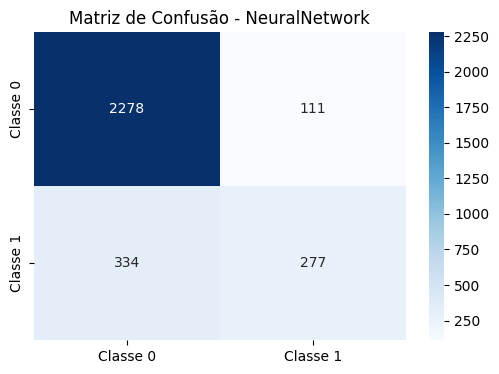


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.66      0.46      0.54       611

    accuracy                           0.84      3000
   macro avg       0.76      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



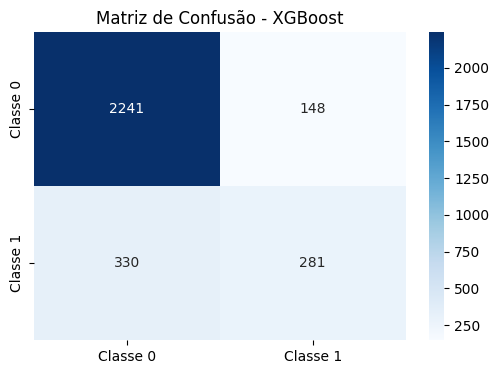


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.66      0.45      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



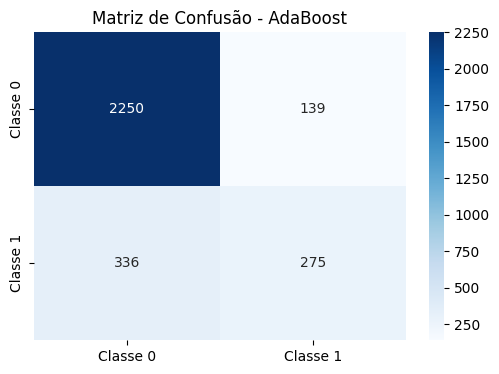


🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
4        DecisionTree  Bal:None|PCA:False|Scl:True          0.479542   
6             XGBoost  Bal:None|PCA:False|Scl:True          0.459902   
5       NeuralNetwork  Bal:None|PCA:False|Scl:True          0.453355   
7            AdaBoost  Bal:None|PCA:False|Scl:True          0.450082   
1        RandomForest  Bal:None|PCA:False|Scl:True          0.422259   
2                 SVM  Bal:None|PCA:False|Scl:True          0.350245   
3                 KNN  Bal:None|PCA:False|Scl:True          0.346972   
0  LogisticRegression  Bal:None|PCA:False|Scl:True          0.201309   

   Recall (1)  Acurácia     Tempo    Params  
4    0.479542  0.781000  0.075937   Default  
6    0.459902  0.840667  0.378606  Ignorado  
5    0.453355  0.851667  3.983666  Ignorado  
7    0.450082  0.841667  0.347021  Ignorado  
1    0.422259  0.857333  1.284083   Default  
2    0.350245  0.851000  0.671290  Ignorado  
3    0.346972  0.824333  0.013542  Ignorado  
0    0.201309  0.810000  0.084870   Default


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Grid + SMOTE
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.89      0.71      0.79      2389
    Classe 1       0.38      0.67      0.48       611

    accuracy                           0.71      3000
   macro avg       0.64      0.69      0.64      3000
weighted avg       0.79      0.71      0.73      3000



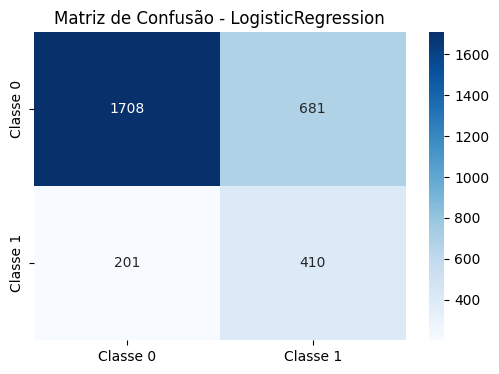

✨ Novo Recorde! LogisticRegression com recall_1: 0.6710

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.88      0.94      0.91      2389
    Classe 1       0.68      0.49      0.57       611

    accuracy                           0.85      3000
   macro avg       0.78      0.72      0.74      3000
weighted avg       0.84      0.85      0.84      3000



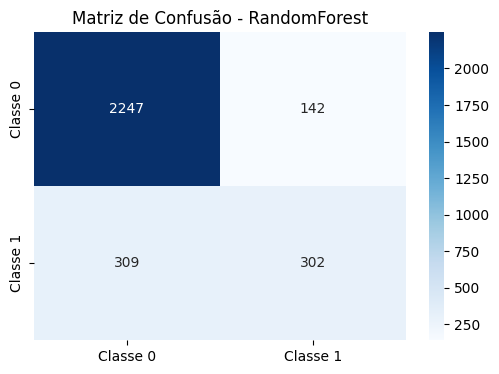


==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.90      0.84      0.87      2389
    Classe 1       0.51      0.64      0.57       611

    accuracy                           0.80      3000
   macro avg       0.71      0.74      0.72      3000
weighted avg       0.82      0.80      0.81      3000



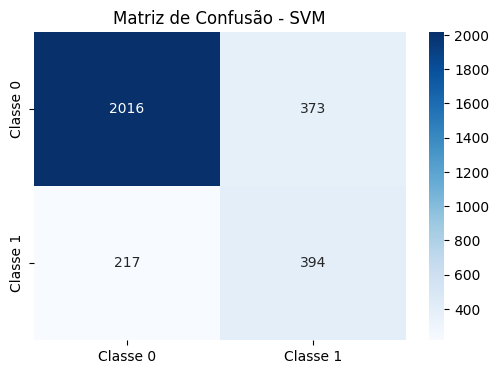


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.89      0.74      0.81      2389
    Classe 1       0.39      0.66      0.49       611

    accuracy                           0.72      3000
   macro avg       0.64      0.70      0.65      3000
weighted avg       0.79      0.72      0.74      3000



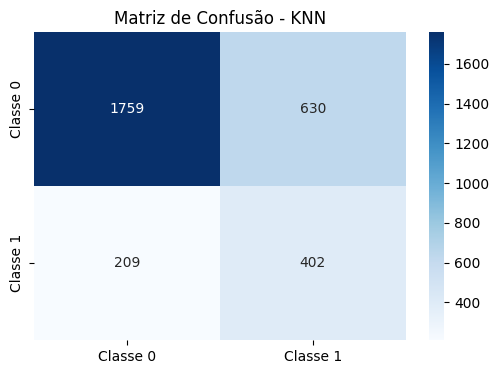


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.84      0.85      2389
    Classe 1       0.45      0.53      0.48       611

    accuracy                           0.77      3000
   macro avg       0.66      0.68      0.67      3000
weighted avg       0.79      0.77      0.78      3000



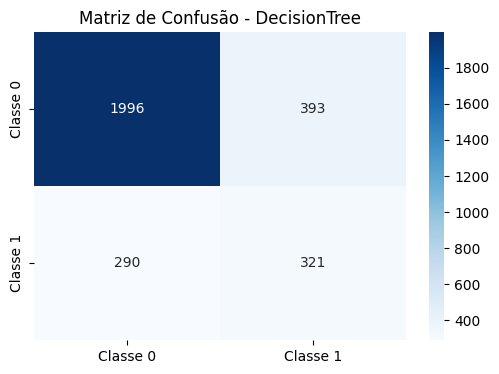


==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.87      0.87      2389
    Classe 1       0.51      0.55      0.53       611

    accuracy                           0.80      3000
   macro avg       0.70      0.71      0.70      3000
weighted avg       0.81      0.80      0.81      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


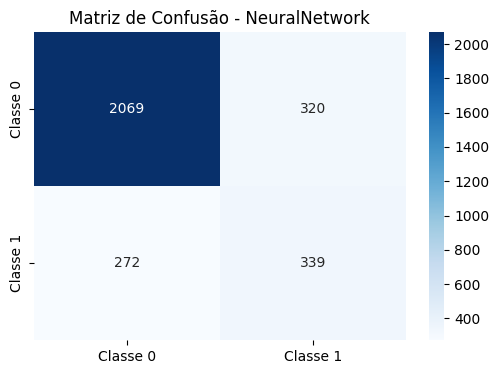


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.94      0.91      2389
    Classe 1       0.68      0.48      0.56       611

    accuracy                           0.85      3000
   macro avg       0.78      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000



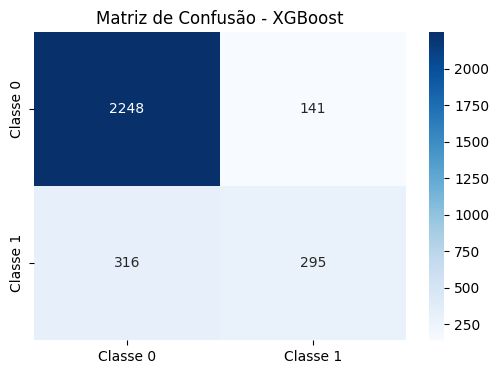


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.90      0.83      0.86      2389
    Classe 1       0.49      0.65      0.56       611

    accuracy                           0.79      3000
   macro avg       0.70      0.74      0.71      3000
weighted avg       0.82      0.79      0.80      3000



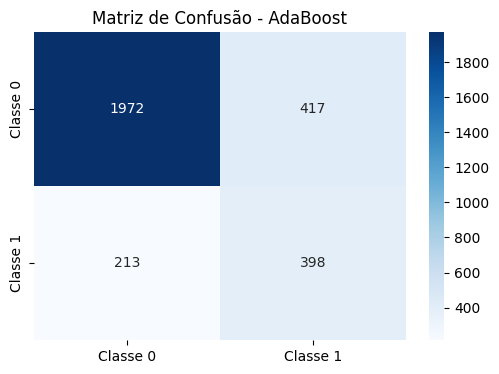


🏆 Resultados:


Modelo                        Config  Score (recall_1)  \
0  LogisticRegression  Bal:SMOTE|PCA:False|Scl:True          0.671031   
3                 KNN  Bal:SMOTE|PCA:False|Scl:True          0.657938   
7            AdaBoost  Bal:SMOTE|PCA:False|Scl:True          0.651391   
2                 SVM  Bal:SMOTE|PCA:False|Scl:True          0.644845   
5       NeuralNetwork  Bal:SMOTE|PCA:False|Scl:True          0.554828   
4        DecisionTree  Bal:SMOTE|PCA:False|Scl:True          0.525368   
1        RandomForest  Bal:SMOTE|PCA:False|Scl:True          0.494272   
6             XGBoost  Bal:SMOTE|PCA:False|Scl:True          0.482815   

   Recall (1)  Acurácia     Tempo    Params  
0    0.671031  0.706000  0.197448   Default  
3    0.657938  0.720333  0.184879  Ignorado  
7    0.651391  0.790000  0.832674  Ignorado  
2    0.644845  0.803333  2.444356  Ignorado  
5    0.554828  0.802667  6.101940  Ignorado  
4    0.525368  0.772333  0.314512  Ignorado  
1    0.494272  0.849667  2.285331  Ignorado  
6    0.482815  0.847667  0.654420  Ignorado


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/LogisticRegression_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Grid + Tomek
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.96      0.89      2389
    Classe 1       0.58      0.24      0.34       611

    accuracy                           0.81      3000
   macro avg       0.71      0.60      0.61      3000
weighted avg       0.78      0.81      0.78      3000



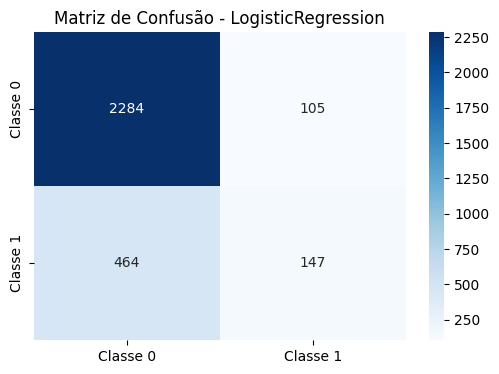

✨ Novo Recorde! LogisticRegression com recall_1: 0.2406

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.73      0.46      0.56       611

    accuracy                           0.86      3000
   macro avg       0.80      0.71      0.74      3000
weighted avg       0.84      0.86      0.84      3000



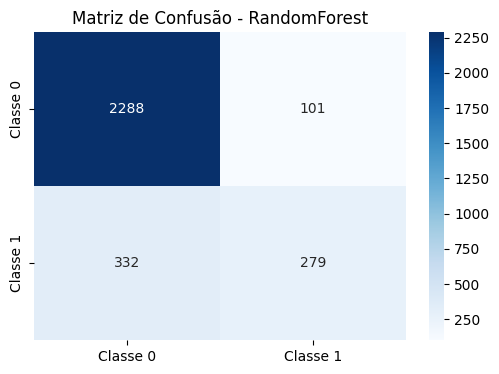

✨ Novo Recorde! RandomForest com recall_1: 0.4566

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.75      0.42      0.54       611

    accuracy                           0.85      3000
   macro avg       0.81      0.69      0.73      3000
weighted avg       0.84      0.85      0.84      3000



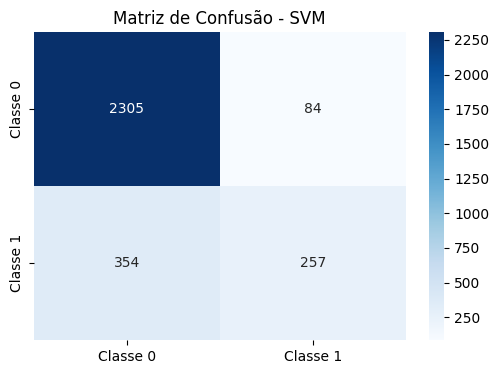


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.86      0.94      0.89      2389
    Classe 1       0.61      0.38      0.47       611

    accuracy                           0.82      3000
   macro avg       0.73      0.66      0.68      3000
weighted avg       0.80      0.82      0.81      3000



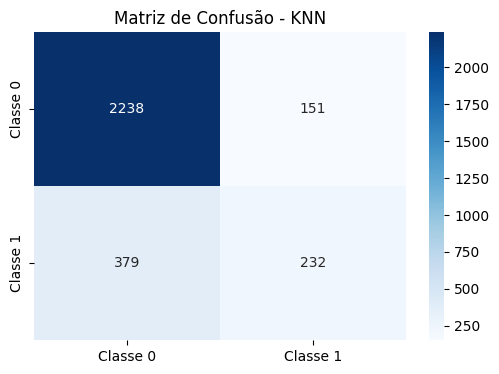


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.88      0.85      0.86      2389
    Classe 1       0.47      0.53      0.50       611

    accuracy                           0.78      3000
   macro avg       0.67      0.69      0.68      3000
weighted avg       0.79      0.78      0.79      3000



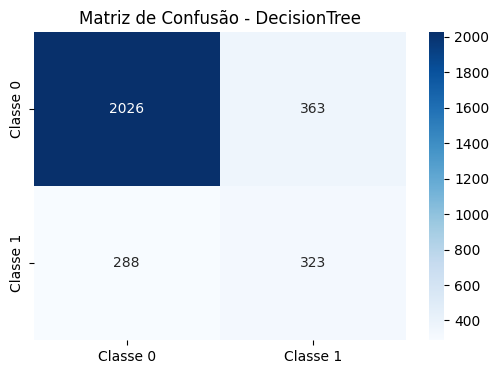

✨ Novo Recorde! DecisionTree com recall_1: 0.5286

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.64      0.52      0.57       611

    accuracy                           0.84      3000
   macro avg       0.76      0.72      0.74      3000
weighted avg       0.83      0.84      0.84      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


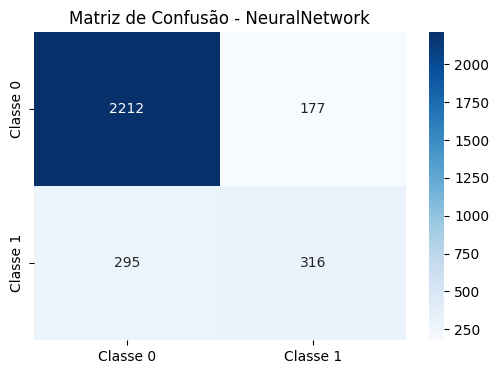


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.63      0.49      0.55       611

    accuracy                           0.84      3000
   macro avg       0.75      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000



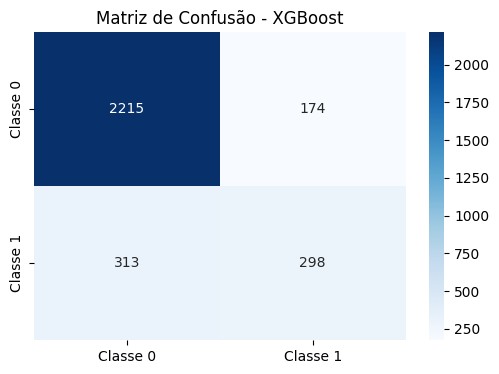


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.64      0.48      0.55       611

    accuracy                           0.84      3000
   macro avg       0.76      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000



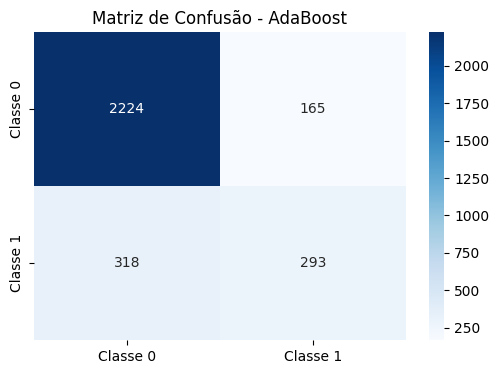


🏆 Resultados:


Modelo                             Config  Score (recall_1)  \
4        DecisionTree  Bal:TomekLinks|PCA:False|Scl:True          0.528642   
5       NeuralNetwork  Bal:TomekLinks|PCA:False|Scl:True          0.517185   
6             XGBoost  Bal:TomekLinks|PCA:False|Scl:True          0.487725   
7            AdaBoost  Bal:TomekLinks|PCA:False|Scl:True          0.479542   
1        RandomForest  Bal:TomekLinks|PCA:False|Scl:True          0.456628   
2                 SVM  Bal:TomekLinks|PCA:False|Scl:True          0.420622   
3                 KNN  Bal:TomekLinks|PCA:False|Scl:True          0.379705   
0  LogisticRegression  Bal:TomekLinks|PCA:False|Scl:True          0.240589   

   Recall (1)  Acurácia     Tempo    Params  
4    0.528642  0.783000  0.226232   Default  
5    0.517185  0.842667  3.872964  Ignorado  
6    0.487725  0.837667  0.464724  Ignorado  
7    0.479542  0.839000  0.511407  Ignorado  
1    0.456628  0.855667  1.390684   Default  
2    0.420622  0.854000  0.791657  Ignorado  
3    0.379705  0.823333  0.110868  Ignorado  
0    0.240589  0.810333  0.149071   Default


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Grid + PCA + SMOTE
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.90      0.72      0.80      2389
    Classe 1       0.38      0.68      0.49       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000



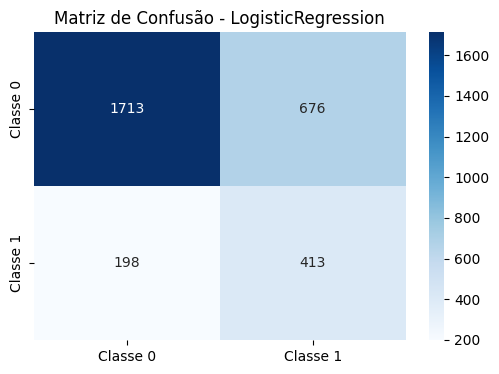

✨ Novo Recorde! LogisticRegression com recall_1: 0.6759

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.88      0.90      0.89      2389
    Classe 1       0.56      0.52      0.54       611

    accuracy                           0.82      3000
   macro avg       0.72      0.71      0.71      3000
weighted avg       0.82      0.82      0.82      3000



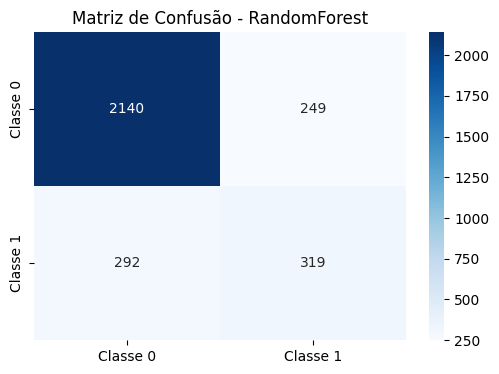


==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.90      0.85      0.87      2389
    Classe 1       0.52      0.65      0.58       611

    accuracy                           0.81      3000
   macro avg       0.71      0.75      0.72      3000
weighted avg       0.83      0.81      0.81      3000



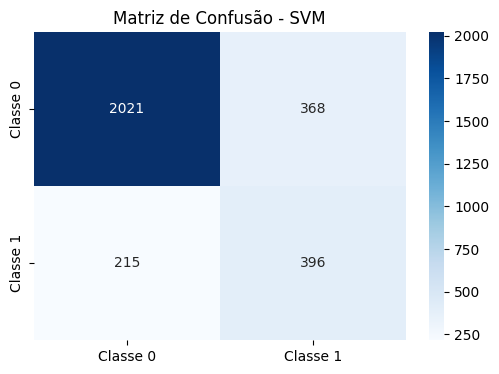


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.89      0.73      0.80      2389
    Classe 1       0.38      0.64      0.48       611

    accuracy                           0.71      3000
   macro avg       0.63      0.69      0.64      3000
weighted avg       0.78      0.71      0.74      3000



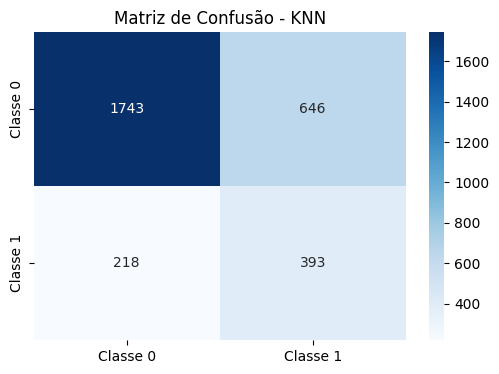


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.79      0.83      2389
    Classe 1       0.39      0.52      0.45       611

    accuracy                           0.74      3000
   macro avg       0.63      0.66      0.64      3000
weighted avg       0.77      0.74      0.75      3000



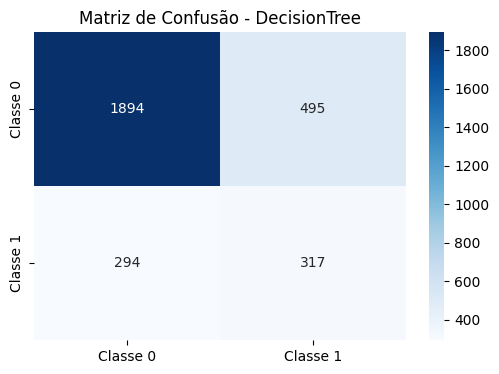


==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.89      0.86      0.88      2389
    Classe 1       0.53      0.59      0.55       611

    accuracy                           0.81      3000
   macro avg       0.71      0.73      0.72      3000
weighted avg       0.82      0.81      0.81      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


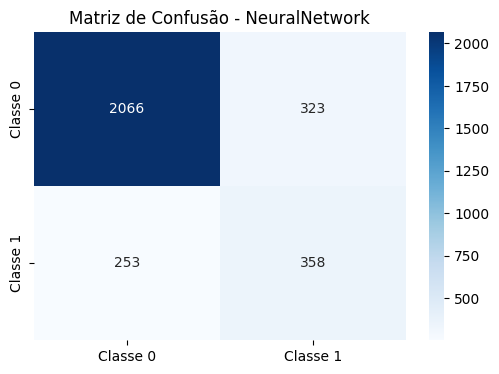


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.89      0.87      0.88      2389
    Classe 1       0.53      0.57      0.55       611

    accuracy                           0.81      3000
   macro avg       0.71      0.72      0.72      3000
weighted avg       0.82      0.81      0.81      3000



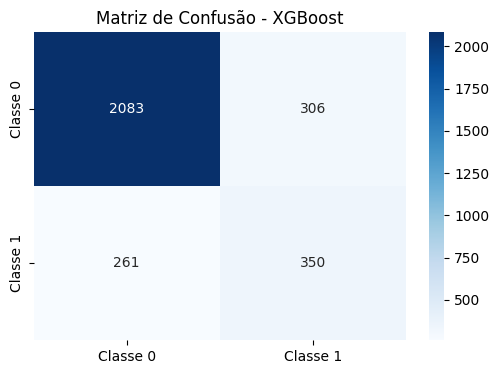


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.91      0.76      0.83      2389
    Classe 1       0.42      0.70      0.53       611

    accuracy                           0.74      3000
   macro avg       0.67      0.73      0.68      3000
weighted avg       0.81      0.74      0.76      3000



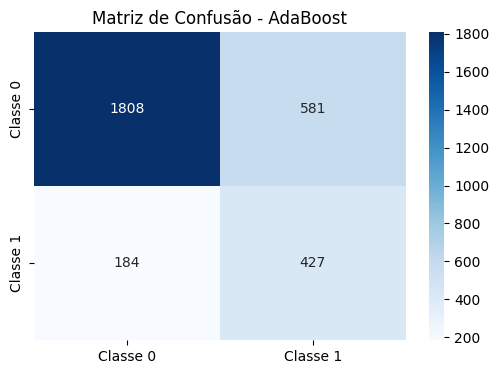

✨ Novo Recorde! AdaBoost com recall_1: 0.6989

🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
7            AdaBoost  Bal:SMOTE|PCA:True|Scl:True          0.698854   
0  LogisticRegression  Bal:SMOTE|PCA:True|Scl:True          0.675941   
2                 SVM  Bal:SMOTE|PCA:True|Scl:True          0.648118   
3                 KNN  Bal:SMOTE|PCA:True|Scl:True          0.643208   
5       NeuralNetwork  Bal:SMOTE|PCA:True|Scl:True          0.585925   
6             XGBoost  Bal:SMOTE|PCA:True|Scl:True          0.572831   
1        RandomForest  Bal:SMOTE|PCA:True|Scl:True          0.522095   
4        DecisionTree  Bal:SMOTE|PCA:True|Scl:True          0.518822   

   Recall (1)  Acurácia     Tempo    Params  
7    0.698854  0.745000  1.536384   Default  
0    0.675941  0.708667  0.180542   Default  
2    0.648118  0.805667  2.397735  Ignorado  
3    0.643208  0.712000  0.198085  Ignorado  
5    0.585925  0.808000  6.358281  Ignorado  
6    0.572831  0.811000  0.614672  Ignorado  
1    0.522095  0.819667  4.237112  Ignorado  
4    0.518822  0.737000  0.471817  Ignorado


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/AdaBoost_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Grid + PCA + Tomek
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.95      0.89      2389
    Classe 1       0.54      0.22      0.31       611

    accuracy                           0.80      3000
   macro avg       0.68      0.59      0.60      3000
weighted avg       0.77      0.80      0.77      3000



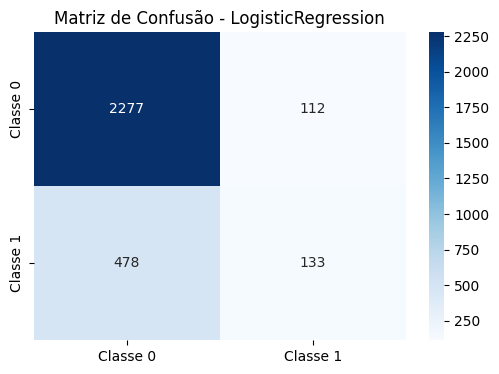

✨ Novo Recorde! LogisticRegression com recall_1: 0.2177

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.73      0.39      0.51       611

    accuracy                           0.85      3000
   macro avg       0.79      0.68      0.71      3000
weighted avg       0.83      0.85      0.83      3000



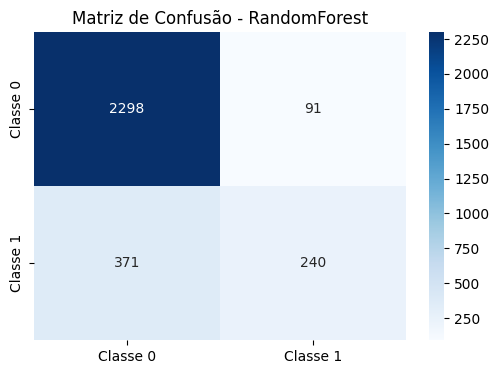

✨ Novo Recorde! RandomForest com recall_1: 0.3928

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.74      0.39      0.51       611

    accuracy                           0.85      3000
   macro avg       0.80      0.68      0.71      3000
weighted avg       0.84      0.85      0.83      3000



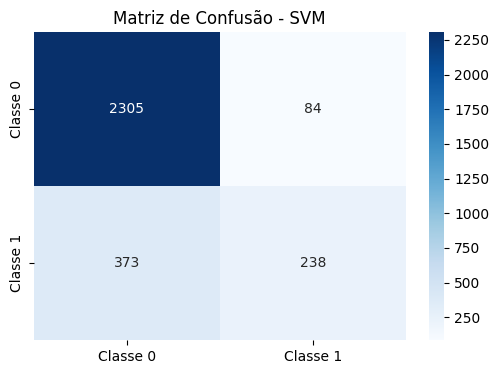


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.86      0.93      0.89      2389
    Classe 1       0.60      0.39      0.47       611

    accuracy                           0.82      3000
   macro avg       0.73      0.66      0.68      3000
weighted avg       0.80      0.82      0.81      3000



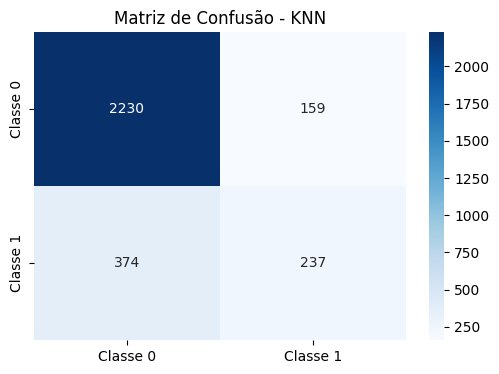


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.85      0.86      2389
    Classe 1       0.47      0.52      0.49       611

    accuracy                           0.78      3000
   macro avg       0.67      0.68      0.67      3000
weighted avg       0.79      0.78      0.78      3000



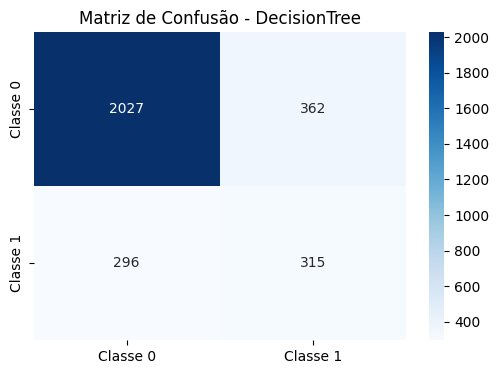

✨ Novo Recorde! DecisionTree com recall_1: 0.5155

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2389
    Classe 1       0.69      0.46      0.55       611

    accuracy                           0.85      3000
   macro avg       0.78      0.70      0.73      3000
weighted avg       0.83      0.85      0.84      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


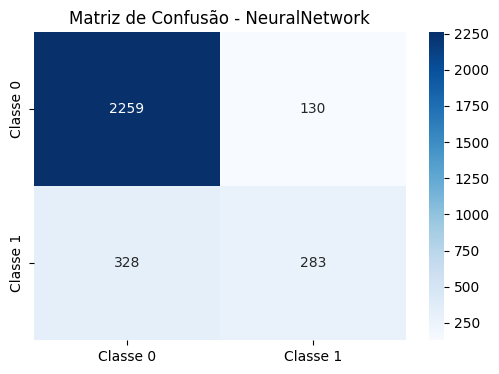


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.63      0.46      0.53       611

    accuracy                           0.84      3000
   macro avg       0.75      0.69      0.72      3000
weighted avg       0.82      0.84      0.83      3000



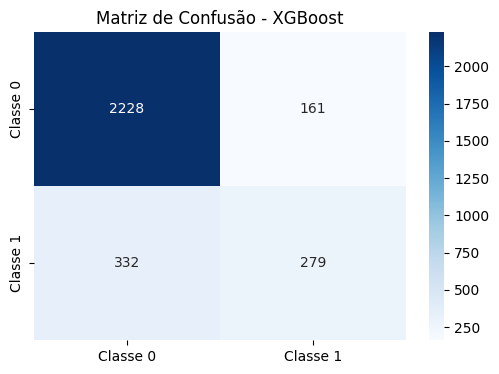


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.84      0.96      0.90      2389
    Classe 1       0.66      0.28      0.39       611

    accuracy                           0.82      3000
   macro avg       0.75      0.62      0.65      3000
weighted avg       0.80      0.82      0.79      3000



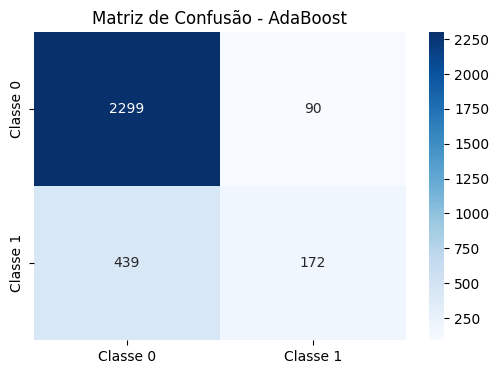


🏆 Resultados:


Modelo                            Config  Score (recall_1)  \
4        DecisionTree  Bal:TomekLinks|PCA:True|Scl:True          0.515548   
5       NeuralNetwork  Bal:TomekLinks|PCA:True|Scl:True          0.463175   
6             XGBoost  Bal:TomekLinks|PCA:True|Scl:True          0.456628   
1        RandomForest  Bal:TomekLinks|PCA:True|Scl:True          0.392799   
2                 SVM  Bal:TomekLinks|PCA:True|Scl:True          0.389525   
3                 KNN  Bal:TomekLinks|PCA:True|Scl:True          0.387889   
7            AdaBoost  Bal:TomekLinks|PCA:True|Scl:True          0.281506   
0  LogisticRegression  Bal:TomekLinks|PCA:True|Scl:True          0.217676   

   Recall (1)  Acurácia     Tempo    Params  
4    0.515548  0.780667  0.353077   Default  
5    0.463175  0.847333  4.383889  Ignorado  
6    0.456628  0.835667  0.602995  Ignorado  
1    0.392799  0.846000  2.824234   Default  
2    0.389525  0.847667  0.792887  Ignorado  
3    0.387889  0.822333  0.143803  Ignorado  
7    0.281506  0.823667  1.061136  Ignorado  
0    0.217676  0.803333  0.147625   Default


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Best
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.97      0.89      2389
    Classe 1       0.60      0.20      0.30       611

    accuracy                           0.81      3000
   macro avg       0.71      0.58      0.60      3000
weighted avg       0.78      0.81      0.77      3000



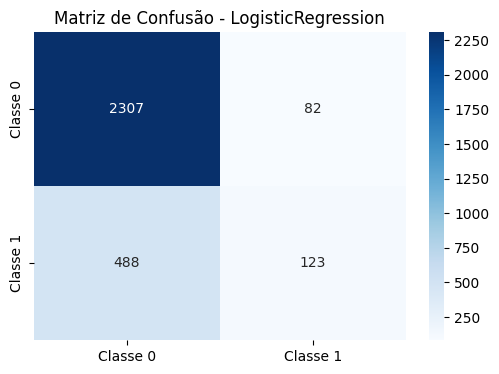

✨ Novo Recorde! LogisticRegression com recall_1: 0.2013

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.97      0.91      2389
    Classe 1       0.76      0.42      0.54       611

    accuracy                           0.85      3000
   macro avg       0.81      0.69      0.73      3000
weighted avg       0.84      0.85      0.84      3000



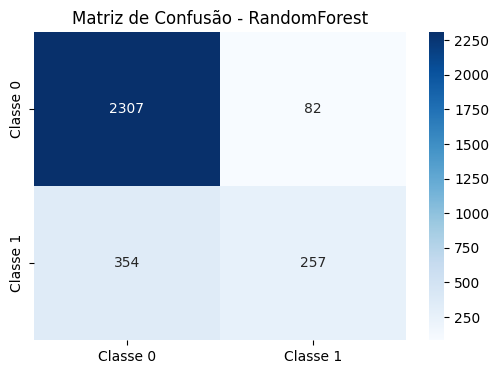

✨ Novo Recorde! RandomForest com recall_1: 0.4206

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.85      0.98      0.91      2389
    Classe 1       0.81      0.35      0.49       611

    accuracy                           0.85      3000
   macro avg       0.83      0.66      0.70      3000
weighted avg       0.85      0.85      0.83      3000



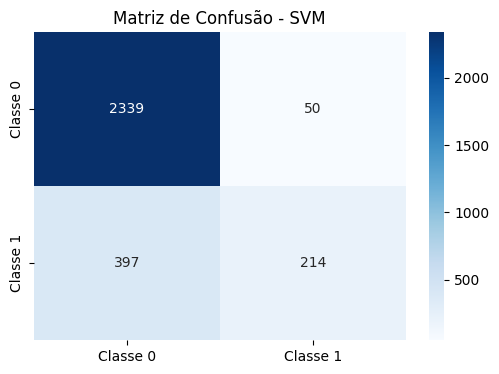


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.85      0.95      0.90      2389
    Classe 1       0.62      0.35      0.45       611

    accuracy                           0.82      3000
   macro avg       0.74      0.65      0.67      3000
weighted avg       0.80      0.82      0.80      3000



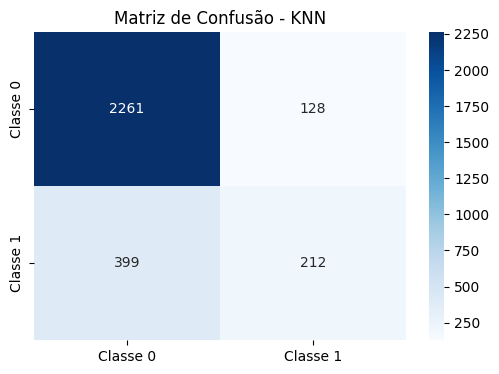


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.87      0.87      2389
    Classe 1       0.48      0.49      0.49       611

    accuracy                           0.79      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.79      0.79      0.79      3000



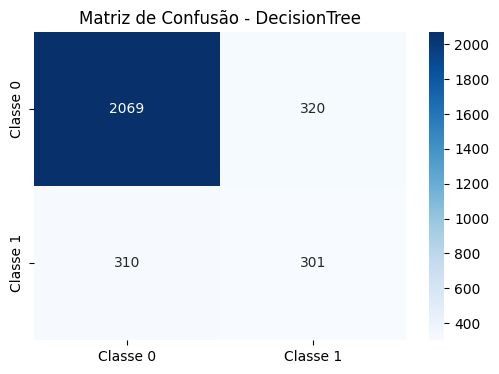

✨ Novo Recorde! DecisionTree com recall_1: 0.4926

==================== NeuralNetwork ====================


c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.72      0.44      0.54       611

    accuracy                           0.85      3000
   macro avg       0.80      0.70      0.73      3000
weighted avg       0.84      0.85      0.84      3000



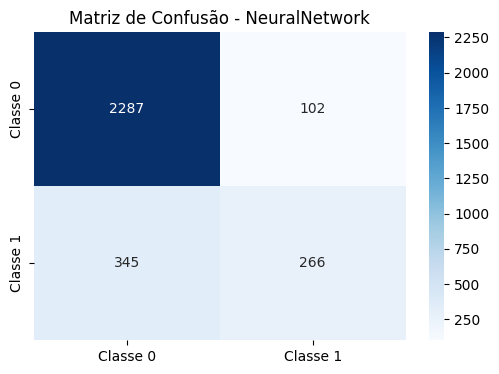


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.66      0.46      0.54       611

    accuracy                           0.84      3000
   macro avg       0.76      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



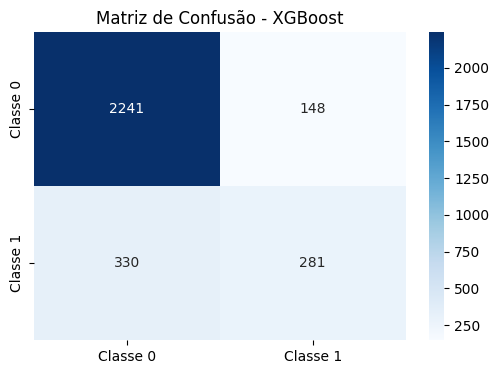


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.66      0.45      0.54       611

    accuracy                           0.84      3000
   macro avg       0.77      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



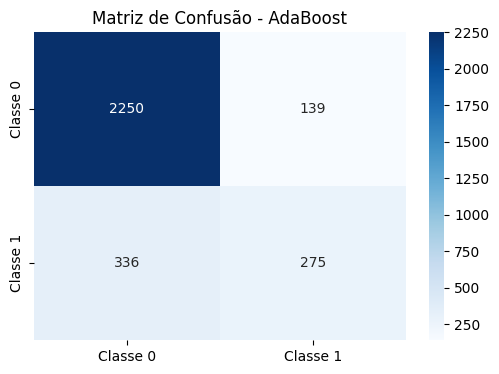


🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
4        DecisionTree  Bal:None|PCA:False|Scl:True          0.492635   
6             XGBoost  Bal:None|PCA:False|Scl:True          0.459902   
7            AdaBoost  Bal:None|PCA:False|Scl:True          0.450082   
5       NeuralNetwork  Bal:None|PCA:False|Scl:True          0.435352   
1        RandomForest  Bal:None|PCA:False|Scl:True          0.420622   
2                 SVM  Bal:None|PCA:False|Scl:True          0.350245   
3                 KNN  Bal:None|PCA:False|Scl:True          0.346972   
0  LogisticRegression  Bal:None|PCA:False|Scl:True          0.201309   

   Recall (1)  Acurácia     Tempo    Params  
4    0.492635  0.790000  0.101032   Default  
6    0.459902  0.840667  0.419538  Ignorado  
7    0.450082  0.841667  0.354632  Ignorado  
5    0.435352  0.851000  4.355100  Ignorado  
1    0.420622  0.854667  1.576993   Default  
2    0.350245  0.851000  0.732890  Ignorado  
3    0.346972  0.824333  0.020891  Ignorado  
0    0.201309  0.810000  0.046305   Default


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Best + SMOTE
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.89      0.71      0.79      2389
    Classe 1       0.38      0.67      0.48       611

    accuracy                           0.71      3000
   macro avg       0.64      0.69      0.64      3000
weighted avg       0.79      0.71      0.73      3000



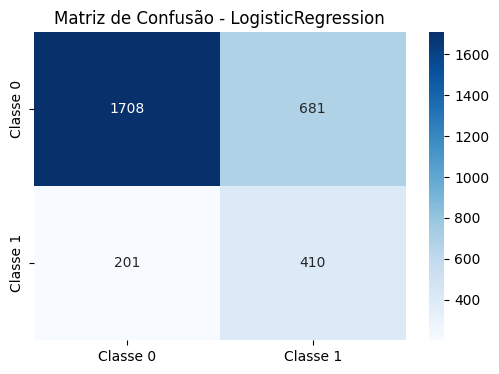

✨ Novo Recorde! LogisticRegression com recall_1: 0.6710

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.88      0.94      0.91      2389
    Classe 1       0.67      0.48      0.56       611

    accuracy                           0.85      3000
   macro avg       0.78      0.71      0.73      3000
weighted avg       0.84      0.85      0.84      3000



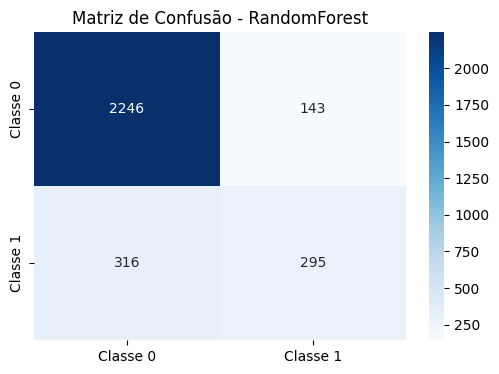


==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.90      0.84      0.87      2389
    Classe 1       0.51      0.64      0.57       611

    accuracy                           0.80      3000
   macro avg       0.71      0.74      0.72      3000
weighted avg       0.82      0.80      0.81      3000



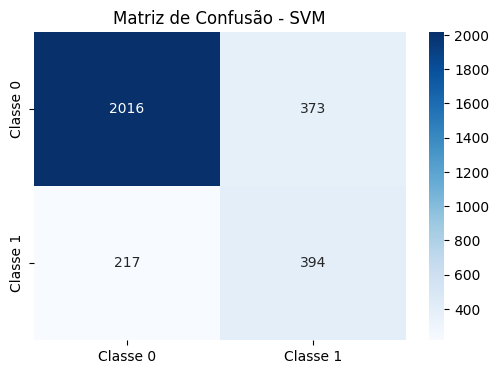


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.89      0.74      0.81      2389
    Classe 1       0.39      0.66      0.49       611

    accuracy                           0.72      3000
   macro avg       0.64      0.70      0.65      3000
weighted avg       0.79      0.72      0.74      3000



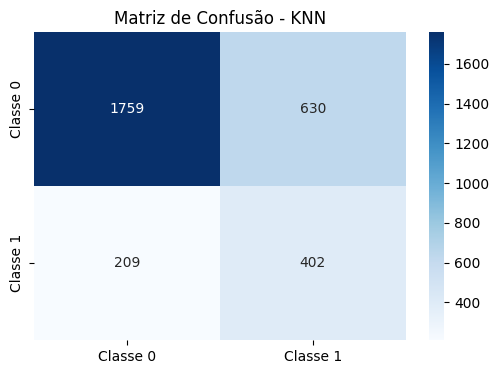


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.85      0.86      2389
    Classe 1       0.47      0.52      0.49       611

    accuracy                           0.78      3000
   macro avg       0.67      0.68      0.68      3000
weighted avg       0.79      0.78      0.79      3000



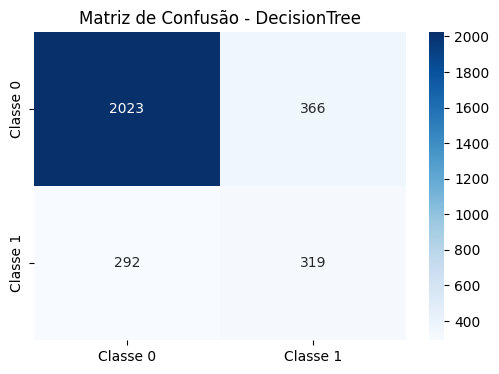


==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.89      0.86      0.87      2389
    Classe 1       0.51      0.58      0.54       611

    accuracy                           0.80      3000
   macro avg       0.70      0.72      0.71      3000
weighted avg       0.81      0.80      0.81      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


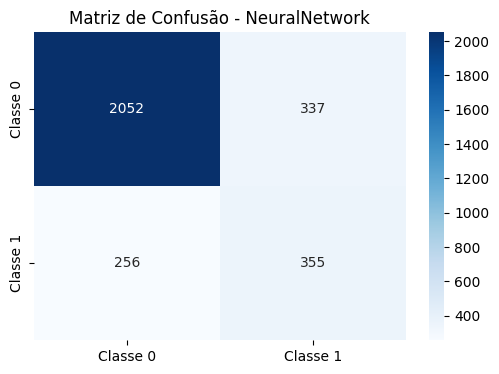


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.94      0.91      2389
    Classe 1       0.68      0.48      0.56       611

    accuracy                           0.85      3000
   macro avg       0.78      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000



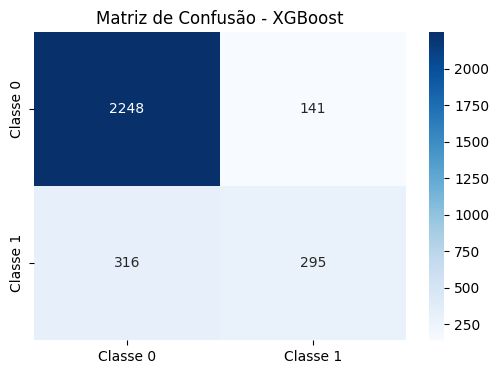


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.90      0.83      0.86      2389
    Classe 1       0.49      0.65      0.56       611

    accuracy                           0.79      3000
   macro avg       0.70      0.74      0.71      3000
weighted avg       0.82      0.79      0.80      3000



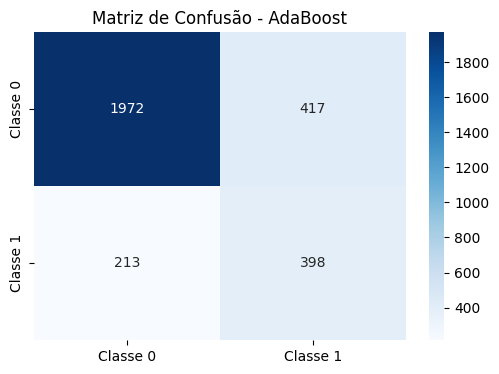


🏆 Resultados:


Modelo                        Config  Score (recall_1)  \
0  LogisticRegression  Bal:SMOTE|PCA:False|Scl:True          0.671031   
3                 KNN  Bal:SMOTE|PCA:False|Scl:True          0.657938   
7            AdaBoost  Bal:SMOTE|PCA:False|Scl:True          0.651391   
2                 SVM  Bal:SMOTE|PCA:False|Scl:True          0.644845   
5       NeuralNetwork  Bal:SMOTE|PCA:False|Scl:True          0.581015   
4        DecisionTree  Bal:SMOTE|PCA:False|Scl:True          0.522095   
1        RandomForest  Bal:SMOTE|PCA:False|Scl:True          0.482815   
6             XGBoost  Bal:SMOTE|PCA:False|Scl:True          0.482815   

   Recall (1)  Acurácia     Tempo    Params  
0    0.671031  0.706000  0.202934   Default  
3    0.657938  0.720333  0.192343  Ignorado  
7    0.651391  0.790000  0.839377  Ignorado  
2    0.644845  0.803333  2.471174  Ignorado  
5    0.581015  0.802333  6.407596  Ignorado  
4    0.522095  0.780667  0.318268  Ignorado  
1    0.482815  0.847000  2.296940  Ignorado  
6    0.482815  0.847667  0.690576  Ignorado


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/LogisticRegression_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Best + Tomek
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.96      0.89      2389
    Classe 1       0.58      0.24      0.34       611

    accuracy                           0.81      3000
   macro avg       0.71      0.60      0.61      3000
weighted avg       0.78      0.81      0.78      3000



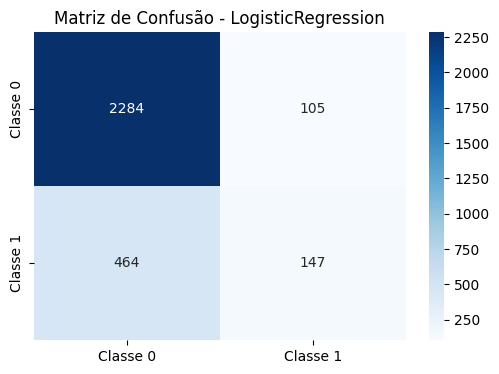

✨ Novo Recorde! LogisticRegression com recall_1: 0.2406

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.73      0.45      0.56       611

    accuracy                           0.85      3000
   macro avg       0.80      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000



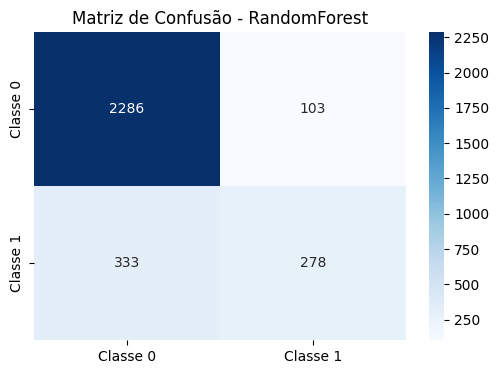

✨ Novo Recorde! RandomForest com recall_1: 0.4550

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.87      0.96      0.91      2389
    Classe 1       0.75      0.42      0.54       611

    accuracy                           0.85      3000
   macro avg       0.81      0.69      0.73      3000
weighted avg       0.84      0.85      0.84      3000



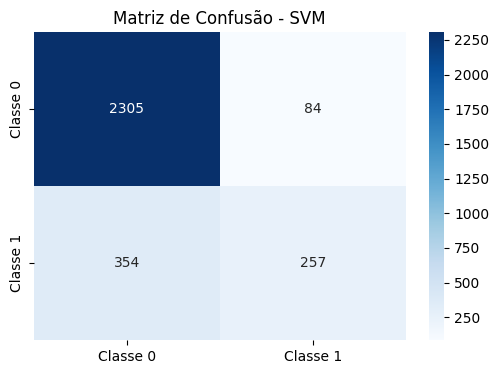


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.86      0.94      0.89      2389
    Classe 1       0.61      0.38      0.47       611

    accuracy                           0.82      3000
   macro avg       0.73      0.66      0.68      3000
weighted avg       0.80      0.82      0.81      3000



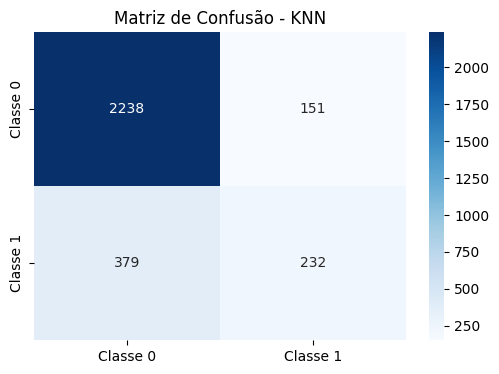


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.88      0.84      0.86      2389
    Classe 1       0.47      0.54      0.50       611

    accuracy                           0.78      3000
   macro avg       0.67      0.69      0.68      3000
weighted avg       0.79      0.78      0.79      3000



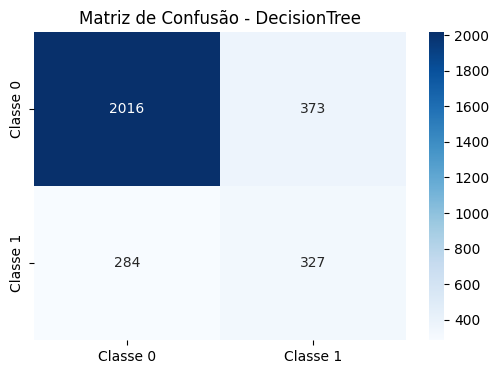

✨ Novo Recorde! DecisionTree com recall_1: 0.5352

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.88      0.94      0.91      2389
    Classe 1       0.67      0.50      0.57       611

    accuracy                           0.85      3000
   macro avg       0.78      0.72      0.74      3000
weighted avg       0.84      0.85      0.84      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


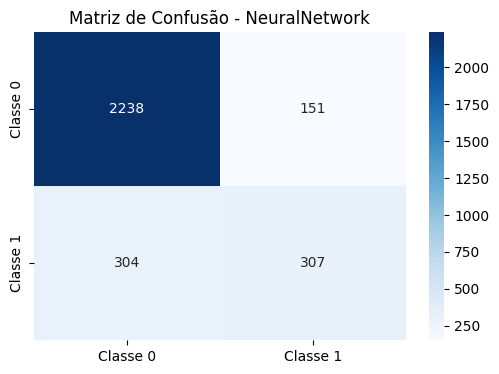


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.88      0.93      0.90      2389
    Classe 1       0.63      0.49      0.55       611

    accuracy                           0.84      3000
   macro avg       0.75      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000



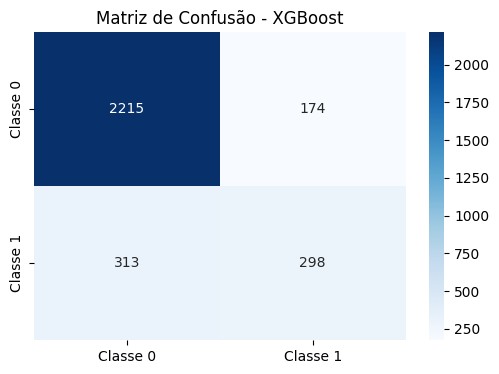


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.64      0.48      0.55       611

    accuracy                           0.84      3000
   macro avg       0.76      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000



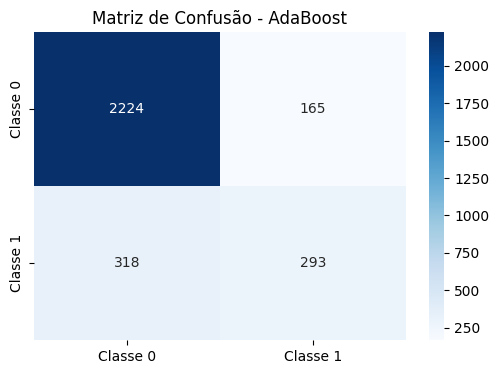


🏆 Resultados:


Modelo                             Config  Score (recall_1)  \
4        DecisionTree  Bal:TomekLinks|PCA:False|Scl:True          0.535188   
5       NeuralNetwork  Bal:TomekLinks|PCA:False|Scl:True          0.502455   
6             XGBoost  Bal:TomekLinks|PCA:False|Scl:True          0.487725   
7            AdaBoost  Bal:TomekLinks|PCA:False|Scl:True          0.479542   
1        RandomForest  Bal:TomekLinks|PCA:False|Scl:True          0.454992   
2                 SVM  Bal:TomekLinks|PCA:False|Scl:True          0.420622   
3                 KNN  Bal:TomekLinks|PCA:False|Scl:True          0.379705   
0  LogisticRegression  Bal:TomekLinks|PCA:False|Scl:True          0.240589   

   Recall (1)  Acurácia     Tempo    Params  
4    0.535188  0.781000  0.244616   Default  
5    0.502455  0.848333  3.923600  Ignorado  
6    0.487725  0.837667  0.495657  Ignorado  
7    0.479542  0.839000  0.518913  Ignorado  
1    0.454992  0.854667  1.393167   Default  
2    0.420622  0.854000  0.778408  Ignorado  
3    0.379705  0.823333  0.116089  Ignorado  
0    0.240589  0.810333  0.150622   Default


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Best + PCA + SMOTE
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.90      0.72      0.80      2389
    Classe 1       0.38      0.68      0.49       611

    accuracy                           0.71      3000
   macro avg       0.64      0.70      0.64      3000
weighted avg       0.79      0.71      0.73      3000



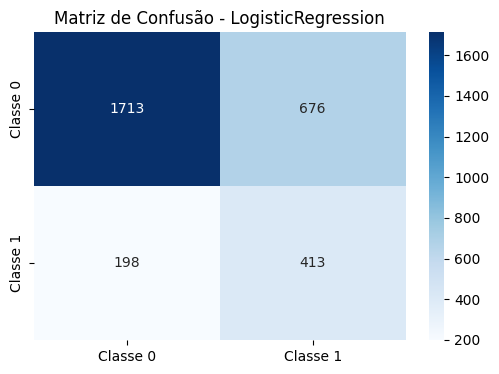

✨ Novo Recorde! LogisticRegression com recall_1: 0.6759

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.88      0.89      0.89      2389
    Classe 1       0.55      0.51      0.53       611

    accuracy                           0.82      3000
   macro avg       0.71      0.70      0.71      3000
weighted avg       0.81      0.82      0.81      3000



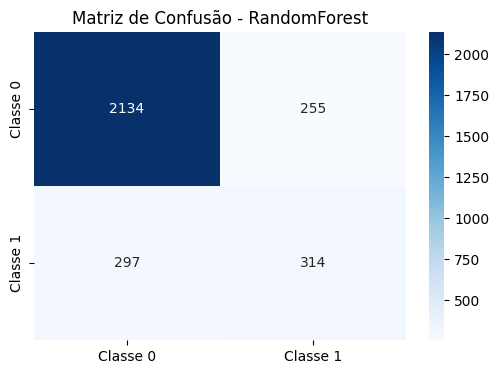


==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.90      0.85      0.87      2389
    Classe 1       0.52      0.65      0.58       611

    accuracy                           0.81      3000
   macro avg       0.71      0.75      0.72      3000
weighted avg       0.83      0.81      0.81      3000



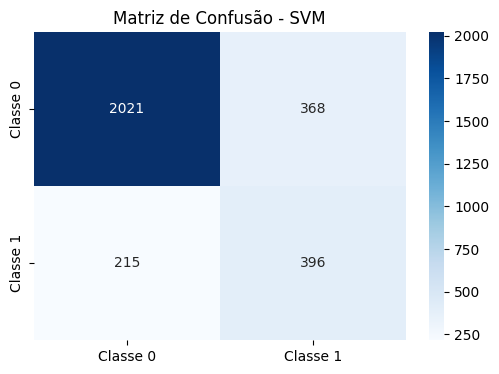


==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.89      0.73      0.80      2389
    Classe 1       0.38      0.64      0.48       611

    accuracy                           0.71      3000
   macro avg       0.63      0.69      0.64      3000
weighted avg       0.78      0.71      0.74      3000



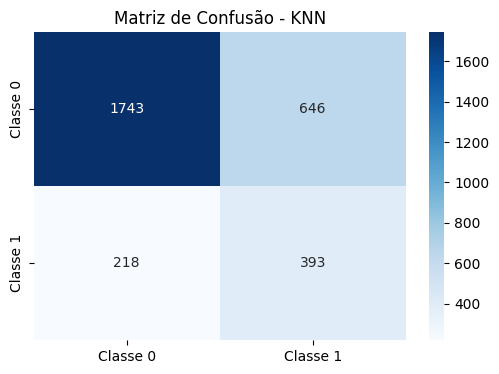


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.80      0.83      2389
    Classe 1       0.40      0.52      0.45       611

    accuracy                           0.75      3000
   macro avg       0.63      0.66      0.64      3000
weighted avg       0.77      0.75      0.76      3000



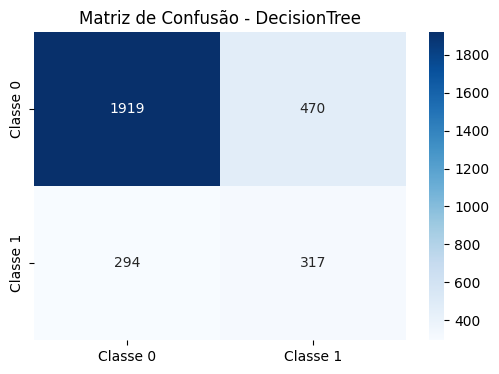


==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.90      0.85      0.87      2389
    Classe 1       0.51      0.61      0.56       611

    accuracy                           0.80      3000
   macro avg       0.70      0.73      0.71      3000
weighted avg       0.82      0.80      0.81      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


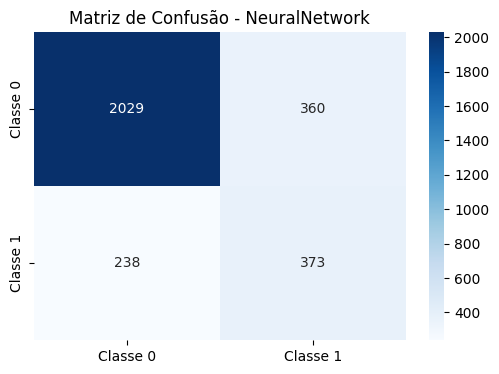


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.89      0.87      0.88      2389
    Classe 1       0.53      0.57      0.55       611

    accuracy                           0.81      3000
   macro avg       0.71      0.72      0.72      3000
weighted avg       0.82      0.81      0.81      3000



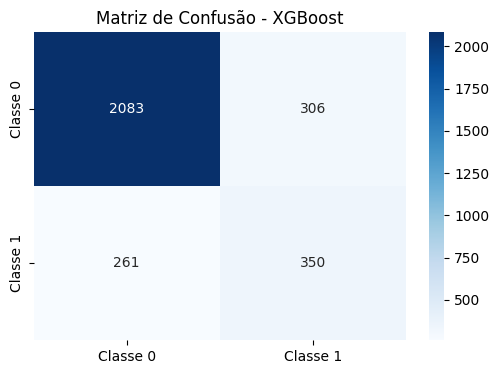


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.91      0.76      0.83      2389
    Classe 1       0.42      0.70      0.53       611

    accuracy                           0.74      3000
   macro avg       0.67      0.73      0.68      3000
weighted avg       0.81      0.74      0.76      3000



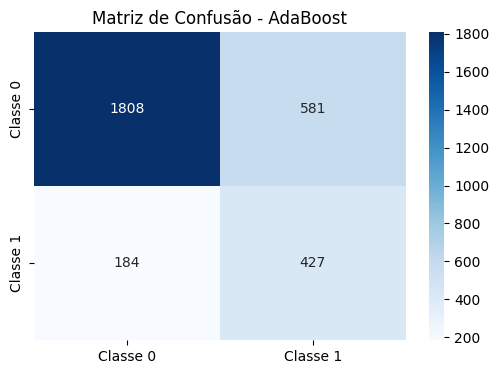

✨ Novo Recorde! AdaBoost com recall_1: 0.6989

🏆 Resultados:


Modelo                       Config  Score (recall_1)  \
7            AdaBoost  Bal:SMOTE|PCA:True|Scl:True          0.698854   
0  LogisticRegression  Bal:SMOTE|PCA:True|Scl:True          0.675941   
2                 SVM  Bal:SMOTE|PCA:True|Scl:True          0.648118   
3                 KNN  Bal:SMOTE|PCA:True|Scl:True          0.643208   
5       NeuralNetwork  Bal:SMOTE|PCA:True|Scl:True          0.610475   
6             XGBoost  Bal:SMOTE|PCA:True|Scl:True          0.572831   
4        DecisionTree  Bal:SMOTE|PCA:True|Scl:True          0.518822   
1        RandomForest  Bal:SMOTE|PCA:True|Scl:True          0.513912   

   Recall (1)  Acurácia     Tempo    Params  
7    0.698854  0.745000  1.562856   Default  
0    0.675941  0.708667  0.194332   Default  
2    0.648118  0.805667  2.466796  Ignorado  
3    0.643208  0.712000  0.220170  Ignorado  
5    0.610475  0.800667  6.305530  Ignorado  
6    0.572831  0.811000  0.628673  Ignorado  
4    0.518822  0.745333  0.491424  Ignorado  
1    0.513912  0.816000  4.327528  Ignorado


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/AdaBoost_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

>>> 🧪 Testando Cenário: Best + PCA + Tomek
🚀 Iniciando treinamento otimizando por: RECALL_1


==================== LogisticRegression ====================
Relatório para LogisticRegression:
              precision    recall  f1-score   support

    Classe 0       0.83      0.95      0.89      2389
    Classe 1       0.54      0.22      0.31       611

    accuracy                           0.80      3000
   macro avg       0.68      0.59      0.60      3000
weighted avg       0.77      0.80      0.77      3000



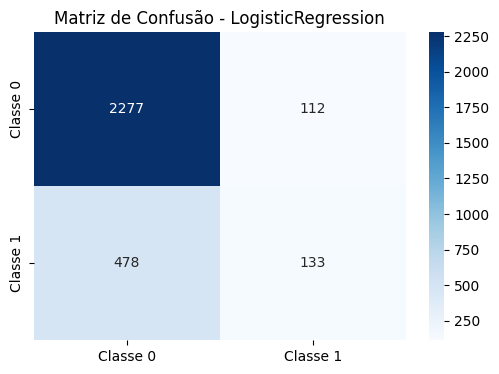

✨ Novo Recorde! LogisticRegression com recall_1: 0.2177

==================== RandomForest ====================
Relatório para RandomForest:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.72      0.38      0.50       611

    accuracy                           0.84      3000
   macro avg       0.79      0.67      0.70      3000
weighted avg       0.83      0.84      0.82      3000



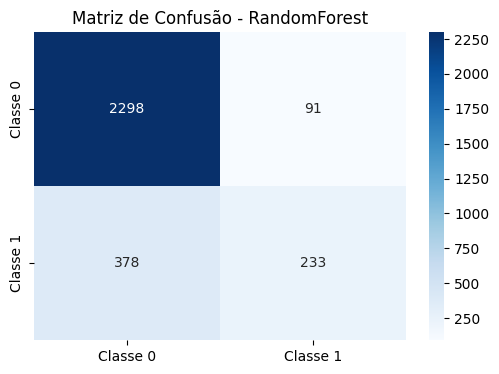

✨ Novo Recorde! RandomForest com recall_1: 0.3813

==================== SVM ====================
Relatório para SVM:
              precision    recall  f1-score   support

    Classe 0       0.86      0.96      0.91      2389
    Classe 1       0.74      0.39      0.51       611

    accuracy                           0.85      3000
   macro avg       0.80      0.68      0.71      3000
weighted avg       0.84      0.85      0.83      3000



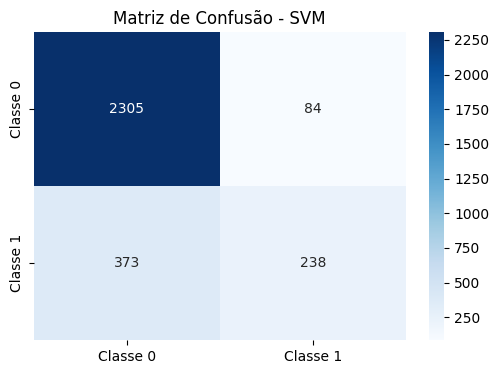

✨ Novo Recorde! SVM com recall_1: 0.3895

==================== KNN ====================
Relatório para KNN:
              precision    recall  f1-score   support

    Classe 0       0.86      0.93      0.89      2389
    Classe 1       0.60      0.39      0.47       611

    accuracy                           0.82      3000
   macro avg       0.73      0.66      0.68      3000
weighted avg       0.80      0.82      0.81      3000



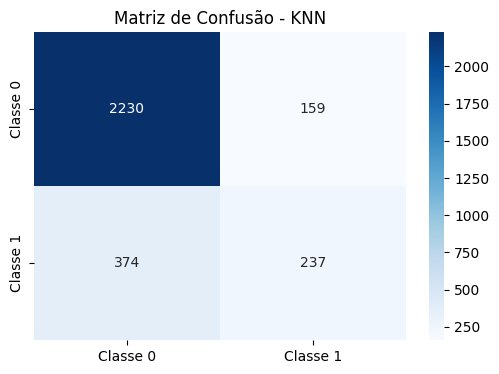


==================== DecisionTree ====================
Relatório para DecisionTree:
              precision    recall  f1-score   support

    Classe 0       0.87      0.84      0.86      2389
    Classe 1       0.45      0.49      0.47       611

    accuracy                           0.77      3000
   macro avg       0.66      0.67      0.66      3000
weighted avg       0.78      0.77      0.78      3000



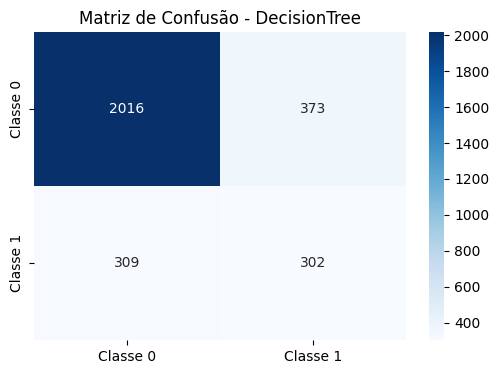

✨ Novo Recorde! DecisionTree com recall_1: 0.4943

==================== NeuralNetwork ====================
Relatório para NeuralNetwork:
              precision    recall  f1-score   support

    Classe 0       0.87      0.94      0.90      2389
    Classe 1       0.65      0.45      0.54       611

    accuracy                           0.84      3000
   macro avg       0.76      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


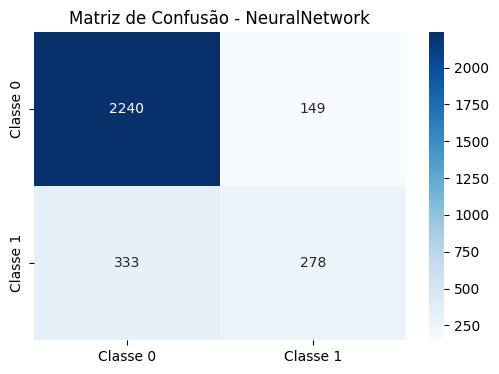


==================== XGBoost ====================
Relatório para XGBoost:
              precision    recall  f1-score   support

    Classe 0       0.87      0.93      0.90      2389
    Classe 1       0.63      0.46      0.53       611

    accuracy                           0.84      3000
   macro avg       0.75      0.69      0.72      3000
weighted avg       0.82      0.84      0.83      3000



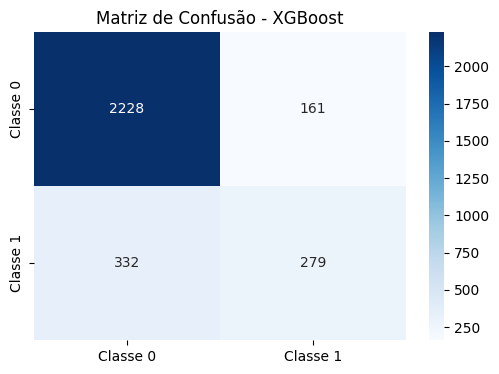


==================== AdaBoost ====================
Relatório para AdaBoost:
              precision    recall  f1-score   support

    Classe 0       0.84      0.96      0.90      2389
    Classe 1       0.66      0.28      0.39       611

    accuracy                           0.82      3000
   macro avg       0.75      0.62      0.65      3000
weighted avg       0.80      0.82      0.79      3000



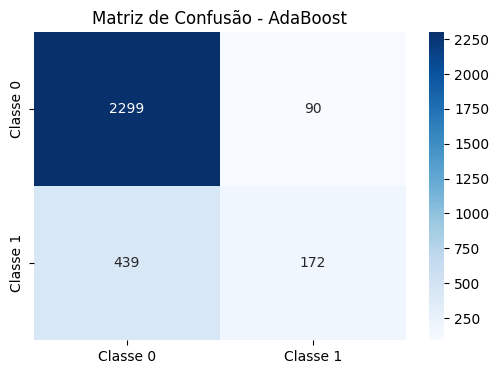


🏆 Resultados:


Modelo                            Config  Score (recall_1)  \
4        DecisionTree  Bal:TomekLinks|PCA:True|Scl:True          0.494272   
6             XGBoost  Bal:TomekLinks|PCA:True|Scl:True          0.456628   
5       NeuralNetwork  Bal:TomekLinks|PCA:True|Scl:True          0.454992   
2                 SVM  Bal:TomekLinks|PCA:True|Scl:True          0.389525   
3                 KNN  Bal:TomekLinks|PCA:True|Scl:True          0.387889   
1        RandomForest  Bal:TomekLinks|PCA:True|Scl:True          0.381342   
7            AdaBoost  Bal:TomekLinks|PCA:True|Scl:True          0.281506   
0  LogisticRegression  Bal:TomekLinks|PCA:True|Scl:True          0.217676   

   Recall (1)  Acurácia     Tempo    Params  
4    0.494272  0.772667  0.355790   Default  
6    0.456628  0.835667  0.632802  Ignorado  
5    0.454992  0.839333  3.926100  Ignorado  
2    0.389525  0.847667  0.760976   Default  
3    0.387889  0.822333  0.159529  Ignorado  
1    0.381342  0.843667  2.793103   Default  
7    0.281506  0.823667  1.618401  Ignorado  
0    0.217676  0.803333  0.146813   Default


💾 Pipeline COMPLETO salvo em: c:\Users\Felipe Botero\Documents\POS\ML_II\bank_customer_churn_analysis\resultados_treino/DecisionTree_PIPELINE_COMPLETO.pkl
   -> Este arquivo está pronto para uso no Streamlit!

🏁 Todos os cenários finalizados!

🏆 Ranking Final dos Cenários:
                  Cenário      Modelo Campeão  Recall_1 Balanceamento    PCA  \
3   Default + PCA + SMOTE            AdaBoost  0.698854         SMOTE   True   
13     Best + PCA + SMOTE            AdaBoost  0.698854         SMOTE   True   
8      Grid + PCA + SMOTE            AdaBoost  0.698854         SMOTE   True   
6            Grid + SMOTE  LogisticRegression  0.671031         SMOTE  False   
11           Best + SMOTE  LogisticRegression  0.671031         SMOTE  False   
1         Default + SMOTE  LogisticRegression  0.671031         SMOTE  False   
12           Best + Tomek        DecisionTree  0.535188    TomekLinks  False   
7            Grid + Tomek        DecisionTree  0.528642    TomekLinks  False   
2    

In [ ]:
resultados_scenarios = []

configs = [
    {"name": "Default",                     "bal": None,           "pca": False, "tipo": "default"},
    {"name": "Default + SMOTE",             "bal": "SMOTE",        "pca": False, "tipo": "default"},
    {"name": "Default + Tomek",             "bal": "TomekLinks",   "pca": False, "tipo": "default"},
    {"name": "Default + PCA + SMOTE",       "bal": "SMOTE",        "pca": True,  "tipo": "default"},
    {"name": "Default + PCA + Tomek",       "bal": "TomekLinks",   "pca": True,  "tipo": "default"},

    {"name": "Grid",                        "bal": None,           "pca": False, "tipo": "grid"},
    {"name": "Grid + SMOTE",                "bal": "SMOTE",        "pca": False, "tipo": "grid"},
    {"name": "Grid + Tomek",                "bal": "TomekLinks",   "pca": False, "tipo": "grid"},
    {"name": "Grid + PCA + SMOTE",          "bal": "SMOTE",        "pca": True,  "tipo": "grid"},
    {"name": "Grid + PCA + Tomek",          "bal": "TomekLinks",   "pca": True,  "tipo": "grid"},

    {"name": "Best",                        "bal": None,           "pca": False, "tipo": "best"},
    {"name": "Best + SMOTE",                "bal": "SMOTE",        "pca": False, "tipo": "best"},
    {"name": "Best + Tomek",                "bal": "TomekLinks",   "pca": False, "tipo": "best"},
    {"name": "Best + PCA + SMOTE",          "bal": "SMOTE",        "pca": True,  "tipo": "best"},
    {"name": "Best + PCA + Tomek",          "bal": "TomekLinks",   "pca": True,  "tipo": "best"},
]

os.makedirs("modelos_campeoes", exist_ok=True)

# Lista onde salvamos os campeões
resultados_scenarios = []

print(f"🚀 Iniciando bateria de testes com {len(configs)} cenários...\n")

for config in configs:
    cenario_nome = config["name"]
    print(f"\n>>> 🧪 Testando Cenário: {cenario_nome}")

    pipeline_cenario = trainer.train(
        metric_optimize='recall_1',
        balanceamento=config["bal"],
        usar_pca=config["pca"],
        tipo_parametros=config["tipo"],
        salvar_parametros=True
    )

    info = trainer.best_model_info

    resultados_scenarios.append({
        "Cenário": cenario_nome,
        "Modelo Campeão": info["name"],
        "Recall_1": info["score"],
        "Balanceamento": config["bal"],
        "PCA": config["pca"],
        "Tipo Param": config["tipo"],
        "Pipeline": pipeline_cenario
    })

    caminho = f"modelos_campeoes/{info['name']}_{cenario_nome.replace(' ', '_')}.pkl"
    joblib.dump(pipeline_cenario, caminho)

print("\n🏁 Todos os cenários finalizados!")

df_resultados = pd.DataFrame(resultados_scenarios)
df_resultados = df_resultados.sort_values(by="Recall_1", ascending=False)

print("\n🏆 Ranking Final dos Cenários:")
cols_display = ["Cenário", "Modelo Campeão", "Recall_1", "Balanceamento", "PCA", "Tipo Param"]
print(df_resultados[cols_display])


melhor_cenario_global = df_resultados.iloc[0]

nome_cenario = melhor_cenario_global['Cenário']
score_vencedor = melhor_cenario_global['Recall_1']
modelo_vencedor = melhor_cenario_global['Modelo Campeão']

print(f"\n🌟 O GRANDE VENCEDOR GLOBAL foi: {modelo_vencedor} ({nome_cenario})")
print(f"   Score: {score_vencedor:.4f}")

pipeline_final = melhor_cenario_global["Pipeline"]

nome_arquivo_final = 'modelo_final_para_streamlit.pkl'
joblib.dump(pipeline_final, nome_arquivo_final)

print(f"\n✅ Arquivo '{nome_arquivo_final}' salvo com sucesso!")


#### Ranking de modelos

In [26]:
try:
  from IPython.display import display
  display(df_resultados[["Cenário", "Modelo Campeão", "Recall_1",  "Balanceamento", "PCA", "Tipo Param"]])
except ImportError:
  print(df_resultados)

Cenário      Modelo Campeão  Recall_1 Balanceamento    PCA  \
3   Default + PCA + SMOTE            AdaBoost  0.698854         SMOTE   True   
13     Best + PCA + SMOTE            AdaBoost  0.698854         SMOTE   True   
8      Grid + PCA + SMOTE            AdaBoost  0.698854         SMOTE   True   
6            Grid + SMOTE  LogisticRegression  0.671031         SMOTE  False   
11           Best + SMOTE  LogisticRegression  0.671031         SMOTE  False   
1         Default + SMOTE  LogisticRegression  0.671031         SMOTE  False   
12           Best + Tomek        DecisionTree  0.535188    TomekLinks  False   
7            Grid + Tomek        DecisionTree  0.528642    TomekLinks  False   
2         Default + Tomek        DecisionTree  0.523732    TomekLinks  False   
9      Grid + PCA + Tomek        DecisionTree  0.515548    TomekLinks   True   
4   Default + PCA + Tomek        DecisionTree  0.509002    TomekLinks   True   
14     Best + PCA + Tomek        DecisionTree  0.494272    TomekLinks   True   
10                   Best        DecisionTree  0.492635          None  False   
5                    Grid        DecisionTree  0.479542          None  False   
0                 Default        DecisionTree  0.474632          None  False   

   Tipo Param  
3     default  
13       best  
8        grid  
6        grid  
11       best  
1     default  
12       best  
7        grid  
2     default  
9        grid  
4     default  
14       best  
10       best  
5        grid  
0     default

#### Aplicando testes com Threshold


In [ ]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

model_pipeline = joblib.load("resultados_treino\AdaBoost_PIPELINE_COMPLETO.pkl")


y_probs = model_pipeline.predict_proba(X_test)[:, 1]

print(f"{'Threshold':<10} | {'Recall (1)':<10} | {'Precision':<10} | {'F1-Score':<10} | {'Acurácia':<10}")
print("-" * 65)

thresholds = np.arange(0.1, 0.95, 0.05)

for t in thresholds:
    preds_t = (y_probs >= t).astype(int)

    rec = recall_score(y_test, preds_t, pos_label=1)
    prec = precision_score(y_test, preds_t, zero_division=0)
    f1 = f1_score(y_test, preds_t)
    acc = accuracy_score(y_test, preds_t)

    print(f"{t:.2f}       | {rec:.4f}     | {prec:.4f}    | {f1:.4f}     | {acc:.4f}")

Threshold  | Recall (1) | Precision  | F1-Score   | Acurácia  
-----------------------------------------------------------------
0.10       | 1.0000     | 0.2037    | 0.3384     | 0.2037
0.15       | 1.0000     | 0.2037    | 0.3384     | 0.2037
0.20       | 1.0000     | 0.2037    | 0.3384     | 0.2037
0.25       | 1.0000     | 0.2037    | 0.3385     | 0.2040
0.30       | 0.9984     | 0.2077    | 0.3439     | 0.2240
0.35       | 0.9902     | 0.2249    | 0.3666     | 0.3030
0.40       | 0.9313     | 0.2560    | 0.4016     | 0.4347
0.45       | 0.8462     | 0.3197    | 0.4641     | 0.6020
0.50       | 0.6989     | 0.4236    | 0.5275     | 0.7450
0.55       | 0.4452     | 0.5271    | 0.4827     | 0.8057
0.60       | 0.1948     | 0.6467    | 0.2994     | 0.8143
0.65       | 0.1015     | 0.9118    | 0.1826     | 0.8150
0.70       | 0.0311     | 1.0000    | 0.0603     | 0.8027
0.75       | 0.0016     | 1.0000    | 0.0033     | 0.7967
0.80       | 0.0000     | 0.0000    | 0.0000     | 0.7963
0

<>:5: SyntaxWarning: invalid escape sequence '\A'
<>:5: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Felipe Botero\AppData\Local\Temp\ipykernel_12764\1133563105.py:5: SyntaxWarning: invalid escape sequence '\A'
  model_pipeline = joblib.load("resultados_treino\AdaBoost_PIPELINE_COMPLETO.pkl")


In [ ]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix

thresholds_zoom = np.arange(0.35, 0.55, 0.01)

print(f"{'Limiar':<7} | {'Recall(1)':<9} | {'Espec(0)':<9} | {'Prec':<9} | {'F1':<9} | {'Acurácia':<9} | {'TP':<4} {'FP':<4} {'TN':<4} {'FN':<4}")
print("-" * 110)

y_probs = model_pipeline.predict_proba(X_test)[:, 1]

for t in thresholds_zoom:
    preds_t = (y_probs >= t).astype(int)

    rec = recall_score(y_test, preds_t, pos_label=1)
    prec = precision_score(y_test, preds_t, zero_division=0)
    f1 = f1_score(y_test, preds_t)
    acc = accuracy_score(y_test, preds_t)

    tn, fp, fn, tp = confusion_matrix(y_test, preds_t).ravel()

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{t:.3f}   | {rec:.4f}    | {specificity:.4f}    | {prec:.4f}    | {f1:.4f}    | {acc:.4f}    | {tp:<4} {fp:<4} {tn:<4} {fn:<4}")

Limiar  | Recall(1) | Espec(0)  | Prec      | F1        | Acurácia  | TP   FP   TN   FN  
--------------------------------------------------------------------------------------------------------------
0.350   | 0.9902    | 0.1272    | 0.2249    | 0.3666    | 0.3030    | 605  2085 304  6   
0.360   | 0.9836    | 0.1603    | 0.2305    | 0.3735    | 0.3280    | 601  2006 383  10  
0.370   | 0.9755    | 0.1938    | 0.2363    | 0.3805    | 0.3530    | 596  1926 463  15  
0.380   | 0.9624    | 0.2256    | 0.2412    | 0.3857    | 0.3757    | 588  1850 539  23  
0.390   | 0.9427    | 0.2692    | 0.2481    | 0.3928    | 0.4063    | 576  1746 643  35  
0.400   | 0.9313    | 0.3077    | 0.2560    | 0.4016    | 0.4347    | 569  1654 735  42  
0.410   | 0.9165    | 0.3524    | 0.2658    | 0.4121    | 0.4673    | 560  1547 842  51  
0.420   | 0.9083    | 0.3947    | 0.2774    | 0.4250    | 0.4993    | 555  1446 943  56  
0.430   | 0.8903    | 0.4487    | 0.2923    | 0.4401    | 0.5387    | 544  1317

🔄 Reconstruindo pesos originais a partir do PCA...


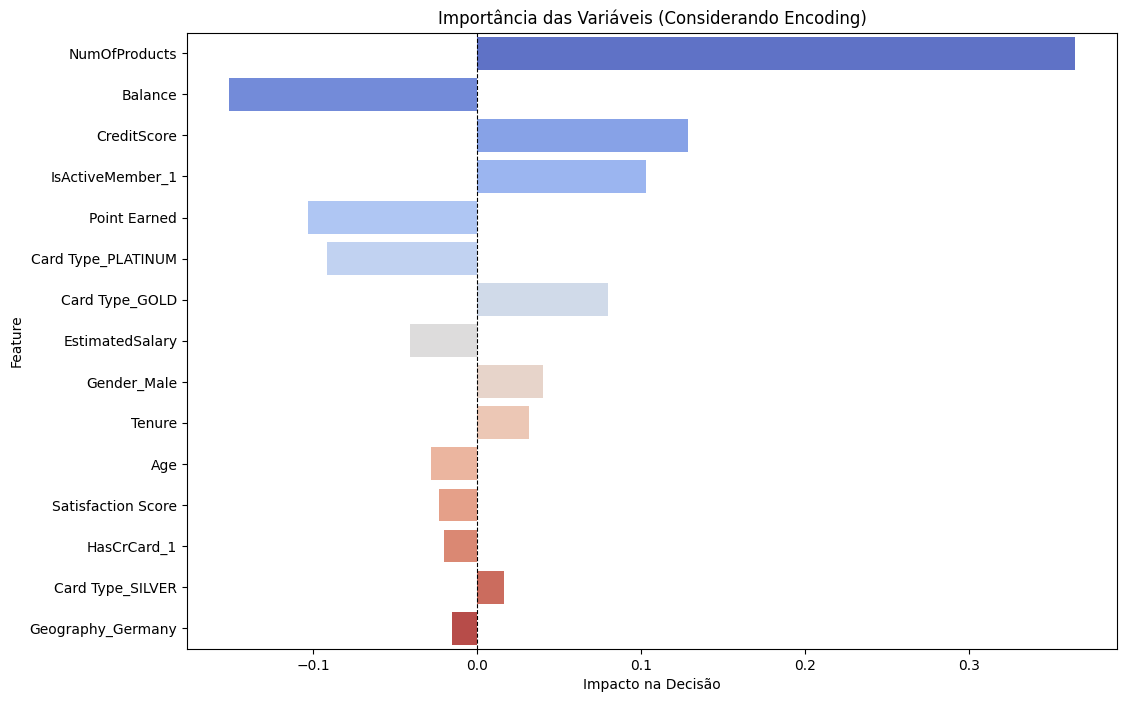

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

try:
    feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
except:
    print("Aviso: Tentando recuperar nomes manualmente...")
    feature_names = model_pipeline.named_steps['preprocessor'].transformers_[0][2] + \
                    list(model_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())

step_pca = model_pipeline.named_steps.get('pca')   
step_model = model_pipeline.named_steps['model']   

if hasattr(step_model, 'coef_'):
    model_weights = step_model.coef_[0]
elif hasattr(step_model, 'feature_importances_'):
    model_weights = step_model.feature_importances_
else:
    raise ValueError("Modelo sem coeficientes acessíveis.")

if step_pca is not None:
    print("🔄 Reconstruindo pesos originais a partir do PCA...")
    pca_components = step_pca.components_
    original_importances = np.dot(model_weights, pca_components)
else:
    print("✅ Sem PCA, usando pesos diretos.")
    original_importances = model_weights

if len(feature_names) != len(original_importances):
    print(f"ERRO DE TAMANHO: Nomes={len(feature_names)} vs Pesos={len(original_importances)}")
    print("Usando índices genéricos para não quebrar...")
    feature_names = [f"Feat_{i}" for i in range(len(original_importances))]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  
    'Importance': original_importances,
    'Abs_Importance': np.abs(original_importances)
}).sort_values(by='Abs_Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feature_importance_df.head(15), 
    palette='coolwarm',
    legend=False
)

plt.title('Importância das Variáveis (Considerando Encoding)')
plt.xlabel('Impacto na Decisão')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

model_pipeline = joblib.load("resultados_treino\LogisticRegression_PIPELINE_COMPLETO.pkl")


y_probs = model_pipeline.predict_proba(X_test)[:, 1]

print(f"{'Threshold':<10} | {'Recall (1)':<10} | {'Precision':<10} | {'F1-Score':<10} | {'Acurácia':<10}")
print("-" * 65)

thresholds = np.arange(0.1, 0.95, 0.05)

for t in thresholds:
    preds_t = (y_probs >= t).astype(int)

    rec = recall_score(y_test, preds_t, pos_label=1)
    prec = precision_score(y_test, preds_t, zero_division=0)
    f1 = f1_score(y_test, preds_t)
    acc = accuracy_score(y_test, preds_t)

    print(f"{t:.2f}       | {rec:.4f}     | {prec:.4f}    | {f1:.4f}     | {acc:.4f}")

Threshold  | Recall (1) | Precision  | F1-Score   | Acurácia  
-----------------------------------------------------------------
0.10       | 0.9951     | 0.2147    | 0.3532     | 0.2577
0.15       | 0.9689     | 0.2280    | 0.3692     | 0.3257
0.20       | 0.9378     | 0.2461    | 0.3899     | 0.4023
0.25       | 0.8969     | 0.2628    | 0.4065     | 0.4667
0.30       | 0.8707     | 0.2849    | 0.4294     | 0.5287
0.35       | 0.8445     | 0.3077    | 0.4510     | 0.5813
0.40       | 0.8020     | 0.3331    | 0.4707     | 0.6327
0.45       | 0.7414     | 0.3564    | 0.4814     | 0.6747
0.50       | 0.6710     | 0.3758    | 0.4818     | 0.7060
0.55       | 0.6072     | 0.4122    | 0.4911     | 0.7437
0.60       | 0.5270     | 0.4357    | 0.4770     | 0.7647
0.65       | 0.4664     | 0.4597    | 0.4630     | 0.7797
0.70       | 0.3961     | 0.4879    | 0.4372     | 0.7923
0.75       | 0.3028     | 0.5110    | 0.3803     | 0.7990
0.80       | 0.2422     | 0.5736    | 0.3406     | 0.8090
0

<>:6: SyntaxWarning: invalid escape sequence '\L'
<>:6: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Felipe Botero\AppData\Local\Temp\ipykernel_12764\1587577015.py:6: SyntaxWarning: invalid escape sequence '\L'
  model_pipeline = joblib.load("resultados_treino\LogisticRegression_PIPELINE_COMPLETO.pkl")


In [ ]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix

thresholds_zoom = np.arange(0.35, 0.55, 0.01)

print(f"{'Limiar':<7} | {'Recall(1)':<9} | {'Espec(0)':<9} | {'Prec':<9} | {'F1':<9} | {'Acurácia':<9} | {'TP':<4} {'FP':<4} {'TN':<4} {'FN':<4}")
print("-" * 110)

y_probs = model_pipeline.predict_proba(X_test)[:, 1]

for t in thresholds_zoom:
    preds_t = (y_probs >= t).astype(int)

    rec = recall_score(y_test, preds_t, pos_label=1)
    prec = precision_score(y_test, preds_t, zero_division=0)
    f1 = f1_score(y_test, preds_t)
    acc = accuracy_score(y_test, preds_t)

    tn, fp, fn, tp = confusion_matrix(y_test, preds_t).ravel()

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{t:.3f}   | {rec:.4f}    | {specificity:.4f}    | {prec:.4f}    | {f1:.4f}    | {acc:.4f}    | {tp:<4} {fp:<4} {tn:<4} {fn:<4}")

Limiar  | Recall(1) | Espec(0)  | Prec      | F1        | Acurácia  | TP   FP   TN   FN  
--------------------------------------------------------------------------------------------------------------
0.350   | 0.8445    | 0.5140    | 0.3077    | 0.4510    | 0.5813    | 516  1161 1228 95  
0.360   | 0.8396    | 0.5283    | 0.3128    | 0.4558    | 0.5917    | 513  1127 1262 98  
0.370   | 0.8298    | 0.5442    | 0.3177    | 0.4594    | 0.6023    | 507  1089 1300 104 
0.380   | 0.8200    | 0.5584    | 0.3220    | 0.4624    | 0.6117    | 501  1055 1334 110 
0.390   | 0.8134    | 0.5726    | 0.3274    | 0.4669    | 0.6217    | 497  1021 1368 114 
0.400   | 0.8020    | 0.5894    | 0.3331    | 0.4707    | 0.6327    | 490  981  1408 121 
0.410   | 0.7889    | 0.6044    | 0.3378    | 0.4730    | 0.6420    | 482  945  1444 129 
0.420   | 0.7807    | 0.6178    | 0.3432    | 0.4768    | 0.6510    | 477  913  1476 134 
0.430   | 0.7692    | 0.6279    | 0.3458    | 0.4772    | 0.6567    | 470  889 

✅ Sem PCA, usando pesos diretos.


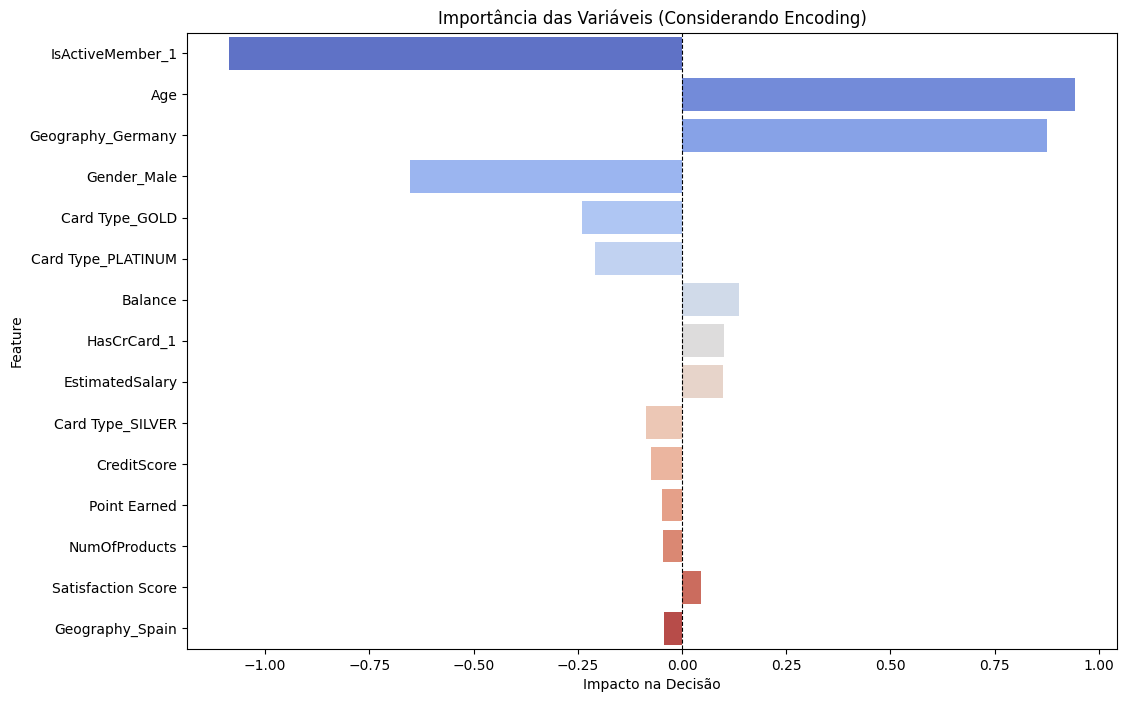

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

try:
    feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
except:
    print("Aviso: Tentando recuperar nomes manualmente...")
    feature_names = model_pipeline.named_steps['preprocessor'].transformers_[0][2] + \
                    list(model_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())

step_pca = model_pipeline.named_steps.get('pca')   
step_model = model_pipeline.named_steps['model']   

if hasattr(step_model, 'coef_'):
    model_weights = step_model.coef_[0]
elif hasattr(step_model, 'feature_importances_'):
    model_weights = step_model.feature_importances_
else:
    raise ValueError("Modelo sem coeficientes acessíveis.")

if step_pca is not None:
    print("🔄 Reconstruindo pesos originais a partir do PCA...")
    pca_components = step_pca.components_
    original_importances = np.dot(model_weights, pca_components)
else:
    print("✅ Sem PCA, usando pesos diretos.")
    original_importances = model_weights

if len(feature_names) != len(original_importances):
    print(f"ERRO DE TAMANHO: Nomes={len(feature_names)} vs Pesos={len(original_importances)}")
    print("Usando índices genéricos para não quebrar...")
    feature_names = [f"Feat_{i}" for i in range(len(original_importances))]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': original_importances,
    'Abs_Importance': np.abs(original_importances)
}).sort_values(by='Abs_Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feature_importance_df.head(15),
    palette='coolwarm',
    legend=False
)

plt.title('Importância das Variáveis (Considerando Encoding)')
plt.xlabel('Impacto na Decisão')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.show()